## 0.0 Imports



In [1057]:
from IPython.display import Image
import pandas as pd
import numpy as np  
import seaborn as sns
from matplotlib import pyplot as plt


# 1.0 Business Understanding

## 1.1. Motivation/Problem (What is the probem? / Who is reporting the issue?)

In the US, Walmart has a system similar to Uber, where delivery drivers 
register to deliver orders placed through the Walmart website. 
These delivery drivers are not Walmart employees, but work independently, 
accepting delivery orders and receiving these orders from Walmart staff, 
then delivering them to the consumer's address. Many consumers have 
reported that certain items in their orders were not delivered, 
even though the system marked the delivery as complete. This raises some 
critical questions:

1. Delivery Driver Fraud: There is evidence that drivers may be reporting 
the delivery of items that did not actually reach the customer. 
They may be omitting or diverting items from the order, 
while still recording the delivery as complete.

2. System or Process Error: It may be that the problem lies in flaws in
the recording system or delivery process, not limited to intentional fraud.

3. Consumer Fraud: In some cases, consumers may claim they did not 
receive a product that was delivered in order to request a refund.

##### Walmart requested the data analyst to identify the potential causes of delivery-related fraud and propose a solution to prevent it.

## 1.2. Poblem Root Cause (Why a solution is requested?)

Customer satisfaction is decreasing due to missing items in completed deliveries.

Revenue losses are increasing due to customer refunds related to reported missing items.

## 1.3. Solution (How to solve the problem?):

Proceed with a descriptive analysis to identify risk patterns and anomalous behaviors, mainly concerning customers, drivers, and potential system errors, that may indicate fraudulent delivery activities.

Develop a fraud risk score framework to estimate the likelihood of risk in future deliveries.

## 1.4. Deliverable:

Presentation file including visualization charts and insights about the main causes of missing items in deliveries.

Interactive dashboard for delivery monitoring.

Fraud risk score framework to identify high-risk delivery patterns.

## 1.5. Tools:

Python: Exploratory Data Analysis and risk metric development.

Power BI: Interactive data visualization.

PowerPoint: Executive presentation of insights.


# 2.0 Data Understanding

The dataset is composed of five distinct tables, each operating at a different level of granularity. Understanding these differences is essential to avoid incorrect aggregations and misleading conclusions during the analysis.

## 2.1 Orders Table

The orders table represents delivery orders placed through Walmart’s e-commerce platform. Each row corresponds to a single order and contains information such as order value, delivery region, delivery time, and the number of items delivered and reported as missing.

It is important to note that the presence of missing items (items_missing > 0) does not confirm fraud, but rather indicates a reported delivery discrepancy.

## 2.2 Missing Items Data

The missing_items_data table contains information only about items reported by customers as not received. This table does not represent the full composition of an order, but only the subset of products that were declared missing.

As a result, this table should not be interpreted as a complete list of items per order, but rather as a complaint-level dataset.

## 2.3 Drivers Data

The drivers_data table provides demographic and operational information about delivery drivers, including age and total number of trips performed during the year. Each driver may be associated with multiple delivery orders.

## 2.4 Customers Data

The customers_data table contains demographic information about customers who placed orders. Similar to drivers, each customer may be associated with multiple orders over time.

## 2.5 Products Data

The products_data table includes information about individual products, such as category and price. Product-level analysis is only possible when this table is joined with the missing items data.

## 2.6 Absence of Fraud Labels

The dataset does not contain an explicit target variable indicating confirmed fraud. Consequently, the analysis cannot rely on supervised machine learning techniques and instead focuses on exploratory analysis, pattern detection, and risk assessment.


# 3.0 Solution Strategy

The solution strategy is diveded into two parts:

1. Exploratory Data Analysis - The objective is not to classify orders as fraudulent, but to prioritize investigations and preventive actions. Given the absence of confirmed fraud labels, the proposed approach focuses on identifying risk patterns and anomalous behaviors that may indicate higher likelihood of delivery-related issues.

2. Fraud risk score framework - The exploratory findings will serve as the foundation for the development of a Fraud Risk Score framework. This framework will aggregate relevant risk indicators identified during the analysis and assign a relative risk level to future delivery orders, supporting preventive monitoring and investigation prioritization.

## 3.1 Exploratory Data Analysis Methodology

The Fact-Dimension method is used to develop the data descriptive analysis.

### 3.1.1 Main (Open) Question

How can delivery-related fraud risk be identified and reduced?

Are there observable patterns in delivery data that indicate higher risk of missing items?

### 3.1.2 Closed Questions

Closed questions are structured, measurable questions that can be answered objectively using the available data. They guide the analytical process and support evidence-based conclusions.

They are divided into two categories:

#### 3.1.2.1 Impact-Level Questions

These questions quantify the magnitude and financial exposure of delivery discrepancies. They measure overall volume and economic impact, but do not identify behavioral concentration or disproportionate risk patterns by themselves.

##### 1. How manny items were not delivered? 

##### 2.What is the total revenue lost due to these undelivered items?

#### 3.1.2.2 Risk-Oriented Questions

These questions analyze proportional metrics across relevant dimensions in order to identify concentration effects, deviations from baseline behavior, and potential anomalous patterns that may indicate elevated delivery-related risk.

##### 3. Do certain drivers present disproportionately higher missing item rates compared to the overall average?

##### 4. Are missing item reports concentrated among a small subset of customers?

##### 5. Are specific product categories more frequently reported as missing?

##### 6. Do certain regions exhibit higher missing item rates?

##### 7. Is there a relationship between delivery time (hour) and missing item occurrences?

### 3.1.3 Defining the fact table

order_id

items_missing

order_amount

items_delivered

revenue_lost (calculated)

### 3.1.4 Defining Dimensions

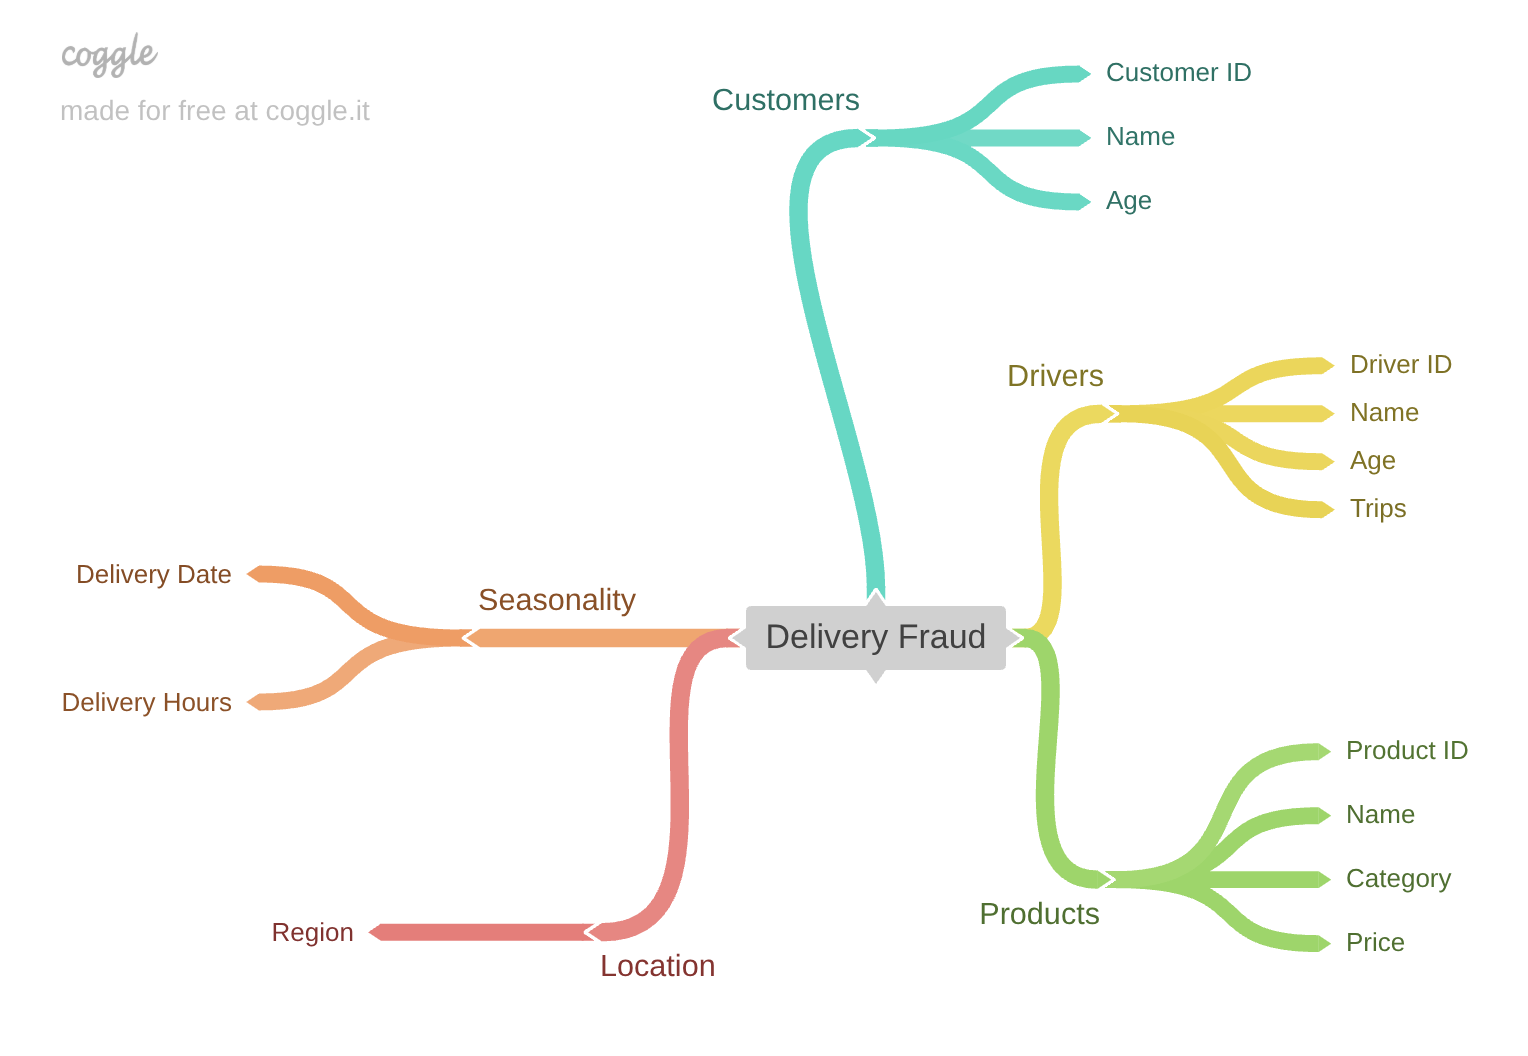

In [1058]:
Image('C:/Users/Igor/Repos/Walmart-Delivery-Fraud-Detection/images/delivery_fraud_dimensions.png')

## 3.2 Fraud Risk Score Framework Methodology

The Fraud Risk Score framework will be developed after identifying statistically and operationally relevant risk indicators during the exploratory analysis.

The framework will:

Select key risk variables derived from the EDA

Normalize and standardize relevant metrics

Combine weighted indicators into a composite risk score

Assign relative risk levels (e.g., low, medium, high) to delivery orders

The score will not represent confirmed fraud probability, but rather a relative risk assessment tool to support preventive decision-making.

## Helper Functions.

In [1059]:
def data_dimensions(df, dataset_name=None):
    if dataset_name:
        print(f'\n=== Data Dimensions Summary: {dataset_name} ===')
    numb_rows = df.shape[0]
    numb_cols = df.shape[1]
    print(f'Number of Rows: {numb_rows}')
    print(f'Number of Columns: {numb_cols}')

    return numb_rows, numb_cols

#--/--

def missing_values_summary(df, dataset_name=None):
    if dataset_name:
        print(f'\n=== Missing Values Summary: {dataset_name} ===')
    missing = (df.isna().sum().reset_index(name='missing_values'))
    missing['missing_%'] = missing['missing_values'] / len(df) * 100
    return missing.sort_values('missing_%', ascending=False)

#--/--

def check_unusual_values(df, 
                         numeric_cols=None, 
                         categorical_cols=None, 
                         id_cols=None,
                         sample=11):
    
    print('='*70)
    print('Checking Unusual / Incoherent Values')
    print('='*70)
    
    
    # ========================
    # Numerical Checks
    # ========================
    
    if numeric_cols:
        print('\n Numerical Columns:\n')
        
        for col in numeric_cols:
            
            if df[col].dtype.kind in 'biufc':
                sorted_values = np.sort(df[col].dropna().values)
            
            # Convert numpy types to Python native types
            sorted_values = [v.item() if hasattr(v, 'item') else v 
                             for v in sorted_values]
            
            if len(sorted_values) > sample * 2:
                preview = (
                    sorted_values[:sample] +
                    ['...'] +
                    sorted_values[-sample:]
                )
            else:
                preview = sorted_values
            
            negative_count = (df[col] < 0).sum()
            
            print(f'Column: {col}')
            print(f'Negative / Non-Numeroic values count: {negative_count}')
            print(f'Sample values: {preview}\n')
    
    
    # ========================
    # ID duplicate checks
    # ========================
    
    if id_cols:
        print('\n Duplicate Checks:\n')
        
        for col in id_cols:
            dup_count = df[col].duplicated().sum()
            dup_len = df[col].nunique() == len(df)
            print(f'Column: {col} → Duplicated values: {dup_count} → Unique values match total rows: {dup_len}')
    
    
    # ========================
    # Categorical Checks
    # ========================
    
    if categorical_cols:
        print('\n Categorical Columns:\n')
        
        for col in categorical_cols:
            
            unique_vals = df[col].dropna().unique()
            preview = sorted(unique_vals[:sample])
            
            # Convert numpy/object types
            unique_vals = [v.item() if hasattr(v, 'item') else v 
                           for v in unique_vals]
            
            if len(unique_vals) > sample:
                preview = unique_vals[:sample] + ['...']
            else:
                preview = unique_vals
            
            print(f'Column: {col}')
            print(f'Unique values sample: {preview}\n')

    return

#--/--

def variables_summary(df, dataset_name=None):
    
    print('='*70)
    if dataset_name:
        print(f'Dataset - {dataset_name}')
    print('='*70)
    
    # =============================
    # Numerical Variables
    # =============================
    
    num = df.select_dtypes(include=['int64', 'float64'])
    
    if not num.empty:
        
        # IQR for outliers
        Q1 = num.quantile(0.25)
        Q3 = num.quantile(0.75)
        IQR = Q3 - Q1
        
        outliers = ((num < (Q1 - 1.5 * IQR)) | 
                    (num > (Q3 + 1.5 * IQR))).sum()
        
        num_summary = num.agg(['min','max','mean','median','std','skew','kurt']).T
        num_summary['range'] = num_summary['max'] - num_summary['min']
        num_summary['outliers_count'] = outliers
        num_summary = num_summary.reset_index().rename(columns={'index':'attribute'})

        # Reorder columns
        num_summary = num_summary[
            ['attribute', 'min', 'max', 'range',
            'mean', 'median', 'std', 'skew', 'kurt',
            'outliers_count']]
        
        print('\n Numerical Summary:\n')
        display(num_summary)
    
    # =============================
    # Categorical Variables
    # =============================
    
    cat = df.select_dtypes(exclude=['int64','float64','datetime64[ns]'])
    
    if not cat.empty:
        
        cat_summary = pd.DataFrame({
            'attribute': cat.columns,
            'unique_values': cat.nunique().values,
            'most_frequent': cat.mode().iloc[0].values,
            'frequency': [
                cat[col].value_counts().iloc[0]
                for col in cat.columns
            ]
        })
        
        print('\n Categorical Summary:\n')
        display(cat_summary)
    
    return

def variables_summary_plots(df):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    for col in numeric_cols:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Histogram
        sns.histplot(df[col], kde=True, ax=axes[0])
        axes[0].set_title(f'Histogram - {col}')

        # Boxplot
        sns.boxplot(x=df[col], ax=axes[1])
        axes[1].set_title(f'Boxplot - {col}')

        plt.tight_layout()
        plt.show()

    return

#--/--

def bar_value(plot, decimals=2, vertical=True, offset=0.01):
    
    for p in plot.patches:
        # Altura ou largura da barra
        if vertical:
            val = p.get_height()
            x = p.get_x() + p.get_width() / 2
            y = val + abs(val) * offset if pd.notnull(val) else 0
        else:
            val = p.get_width()
            x = val + abs(val) * offset if pd.notnull(val) else 0
            y = p.get_y() + p.get_height() / 2
        
        # Apenas se o valor não for NaN
        if pd.notnull(val):
            plot.text(
                x=x,
                y=y,
                s=f'{val:.{decimals}f}',
                ha='center' if vertical else 'left',
                va='bottom' if vertical else 'center'
            )

# # Count plot vertical
# plot_1 = df.groupby('period')['items_missing'].count().plot(kind='bar')
# bar_value(plot_1, decimals=0)  # count -> sem casas decimais

# # Mean plot vertical
# plot_2 = df.groupby('period')['items_missing'].mean().plot(kind='bar')
# bar_value(plot_2, decimals=2)  # média -> 2 casas decimais

# # Horizontal bar plot
# plot_3 = df.groupby('period')['items_missing'].mean().plot(kind='barh')
# bar_value(plot_3, decimals=2, vertical=False)

#--/--

def analyze_missing_rate(df, group_col, overall_rate, 
                         show_chart=True, max_bars=20, min_orders=10):
    
    analysis = df.groupby(group_col).agg(
        missing_rate=('missing_flag', 'mean'),
        avg_revenue_loss=('revenue_loss', 'mean'),
        total_orders=('order_id', 'count')
    ).reset_index()
    
    # Remove grupos com baixo volume
    analysis = analysis[analysis['total_orders'] >= min_orders]
    
    analysis['above_avg_missing'] = analysis['missing_rate'] > overall_rate
    
    total_above = analysis['above_avg_missing'].sum()
    unique_items = analysis[group_col].nunique()
    pct_above = total_above / unique_items if unique_items > 0 else 0
    
    print(f"\n--- Analysis for: {group_col} ---")
    print(f"Total groups (after volume filter): {unique_items}")
    print(f"Groups above average: {total_above} ({pct_above:.2%})")
    
    if show_chart and unique_items <= max_bars:
        plt.figure(figsize=(10, 6))
        palette = {True: 'salmon', False: 'lightgrey'}
        
        sns.barplot(
            data=analysis.sort_values('missing_rate', ascending=False),
            x=group_col, 
            y='missing_rate', 
            hue='above_avg_missing',
            palette=palette,
            dodge=False
        )
        
        plt.axhline(overall_rate, color='red', linestyle='--')
        plt.title(f'Missing Rate by {group_col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    return analysis.sort_values('missing_rate', ascending=False)

   

#--/--

def export_eda_to_excel(file_name, missing=None, num_summary=None, cat_summary=None):
    
    with pd.ExcelWriter(file_name) as writer:
        
        if missing is not None and not missing.empty:
            missing.to_excel(writer, sheet_name='Missing', index=False)
            
        if num_summary is not None and not num_summary.empty:
            num_summary.to_excel(writer, sheet_name='Numerical', index=False)
            
        if cat_summary is not None:
            cat_summary.to_excel(writer, sheet_name='Categorical', index=False)
    
    print(f'\n Report exported to {file_name}')

# 4.0 Data Description

## 4.1 Loading data

In [1060]:
data_path = 'C:/Users/Igor/Repos/Walmart-Delivery-Fraud-Detection/datasets/'

df_orders_raw = pd.read_csv (data_path + 'orders.csv', low_memory=False)
df_missing_items_raw = pd.read_csv (data_path + 'missing_items_data.csv', low_memory=False)
df_products_raw = pd.read_csv (data_path + 'products_data.csv', low_memory=False)
df_customers_raw = pd.read_csv (data_path + 'customers_data.csv', low_memory=False)
df_drivers_raw = pd.read_csv (data_path + 'drivers_data.csv', low_memory=False)

In [1061]:
df_orders_raw.sample()

,date,order_id,order_amount,region,items_delivered,items_missing,delivery_hour,driver_id,customer_id
5795,01/08/2023,8783fcee-4965-4e67-809a-30c7bd58459c,$263.27,Apopka,17,0,12:36:54,WDID10783,WCID5062


In [1062]:
df_missing_items_raw.sample()

,order_id,product_id_1,product_id_2,product_id_3
638,ccacc183-09f8-4fd5-af35-009d18656326,PWPX0982761091004,NaN,NaN


In [1063]:
df_products_raw.sample()

,produc_id,product_name,category,price
48,PWPX0982761091096,Cooking Spray,Supermarket,$12.44


In [1064]:
df_customers_raw.sample()

,customer_id,customer_name,customer_age
279,WCID5946,Katherine Brown,19


In [1065]:
df_drivers_raw.sample()

,driver_id,driver_name,age,Trips
186,WDID10506,Timothy Brown,37,12


In [1066]:
df_orders_1 = df_orders_raw.copy()
df_missing_items_1 = df_missing_items_raw.copy()
df_products_1 = df_products_raw.copy()
df_customers_1 = df_customers_raw.copy()
df_drivers_1 = df_drivers_raw.copy()

## 4.2 Columns Rename

In [1067]:
print(df_orders_1.columns, '\n')
print(df_missing_items_1.columns, '\n')
print(df_products_1.columns, '\n')
print(df_customers_1.columns, '\n')
print(df_drivers_1.columns)

Index(['date', 'order_id', 'order_amount', 'region', 'items_delivered',
       'items_missing', 'delivery_hour', 'driver_id', 'customer_id'],
      dtype='object') 

Index(['order_id', 'product_id_1', 'product_id_2', 'product_id_3'], dtype='object') 

Index(['produc_id', 'product_name', 'category', 'price'], dtype='object') 

Index(['customer_id', 'customer_name', 'customer_age'], dtype='object') 

Index(['driver_id', 'driver_name', 'age', 'Trips'], dtype='object')


In [1068]:
# Columns that need to be renamed:
# Dataset df_products_1 - 'produc_id', 'category', 'price'.
# Dataset df_missing_items - 'product_id_1', 'product_id_2', 'product_id_3'.
# Dataset df_drivers - 'age' and 'Trips'.

df_products_1 = df_products_1.rename(columns={'produc_id': 'product_id', 'category': 'product_category', 'price': 'product_price'})
df_missing_items_1 = df_missing_items_1.rename(columns={'product_id_1': 'missing_product_id_1', 'product_id_2': 'missing_product_id_2', 'product_id_3': 'missing_product_id_3'})
df_drivers_1 = df_drivers_1.rename(columns={'age': 'driver_age', 'Trips': 'driver_trips'})

In [1069]:
print(df_products_1.columns, '\n')
print(df_missing_items_1.columns, '\n')
print(df_drivers_1.columns)

Index(['product_id', 'product_name', 'product_category', 'product_price'], dtype='object') 

Index(['order_id', 'missing_product_id_1', 'missing_product_id_2',
       'missing_product_id_3'],
      dtype='object') 

Index(['driver_id', 'driver_name', 'driver_age', 'driver_trips'], dtype='object')


## 4.3 Data Dimensions

In [1070]:
print(data_dimensions(df_orders_1, 'Orders Dataset'), '\n')
print(data_dimensions(df_missing_items_1, 'Missing Items Dataset'), '\n')
print(data_dimensions(df_products_1, 'Products Dataset'), '\n')
print(data_dimensions(df_customers_1, 'Customer Dataset'), '\n')
print(data_dimensions(df_drivers_1, 'Drivers Dataset'))



=== Data Dimensions Summary: Orders Dataset ===
Number of Rows: 10000
Number of Columns: 9
(10000, 9) 


=== Data Dimensions Summary: Missing Items Dataset ===
Number of Rows: 1502
Number of Columns: 4
(1502, 4) 


=== Data Dimensions Summary: Products Dataset ===
Number of Rows: 314
Number of Columns: 4
(314, 4) 


=== Data Dimensions Summary: Customer Dataset ===
Number of Rows: 1239
Number of Columns: 3
(1239, 3) 


=== Data Dimensions Summary: Drivers Dataset ===
Number of Rows: 1247
Number of Columns: 4
(1247, 4)


## 4.4 Data Types

### 4.4.1 Orders Dataset

In [1071]:
df_orders_1.dtypes

# Necessary to update few columns types.

date               object
order_id           object
order_amount       object
region             object
items_delivered     int64
items_missing       int64
delivery_hour      object
driver_id          object
customer_id        object
dtype: object

In [1072]:
# Before to update the column order_amount from object to float, it is necessary to remove the dollar sign $.
df_orders_1['order_amount'] = (df_orders_1['order_amount'].str.replace('$', '', regex=False).str.replace(',', '', regex=False))

# Updating the colums type.
df_orders_1['date'] = pd.to_datetime( df_orders_1['date'].str.replace( '-' , '/' ), dayfirst=True, errors = 'coerce' )
df_orders_1['delivery_hour'] = pd.to_datetime(df_orders_1['delivery_hour'],format='%H:%M:%S',errors='coerce')
df_orders_1['order_amount'] = df_orders_1['order_amount'].astype('float64')
df_orders_1['items_delivered'] = df_orders_1['items_delivered'].astype('int64')
df_orders_1['items_missing'] = df_orders_1['items_missing'].astype('int64')

In [1073]:
df_orders_1.dtypes

date               datetime64[ns]
order_id                   object
order_amount              float64
region                     object
items_delivered             int64
items_missing               int64
delivery_hour      datetime64[ns]
driver_id                  object
customer_id                object
dtype: object

### 4.4.2 Missing Items Dataset

In [1074]:
df_missing_items_1.dtypes

# Not necessary to update the columns types.

order_id                object
missing_product_id_1    object
missing_product_id_2    object
missing_product_id_3    object
dtype: object

### 4.4.3 Products Dataset

In [1075]:
df_products_1.dtypes

# Necessary to update few columns types.

product_id          object
product_name        object
product_category    object
product_price       object
dtype: object

In [1076]:
# Before to update the column product_price from object to float, it is necessary to remove the dollar sign $.
df_products_1['product_price'] = (df_products_1['product_price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False))

# Updating the colums type.
df_products_1['product_price'] = df_products_1['product_price'].astype('float64')

In [1077]:
df_products_1.dtypes

product_id           object
product_name         object
product_category     object
product_price       float64
dtype: object

### 4.4.4 Customers Dataset

In [1078]:
df_customers_1.dtypes

# Not necessary to update the columns types.

customer_id      object
customer_name    object
customer_age      int64
dtype: object

### 4.4.5 Drivers Dataset

In [1079]:
df_drivers_1.dtypes

# Not necessary to update the columns types.

driver_id       object
driver_name     object
driver_age       int64
driver_trips     int64
dtype: object

## 4.5 Check NA

### 4.5.1 Orders Dataset

In [1080]:
missing_values_summary(df_orders_1, 'Orders')



=== Missing Values Summary: Orders ===


,index,missing_values,missing_%
0,date,0,0.0
1,order_id,0,0.0
2,order_amount,0,0.0
3,region,0,0.0
4,items_delivered,0,0.0
5,items_missing,0,0.0
6,delivery_hour,0,0.0
7,driver_id,0,0.0
8,customer_id,0,0.0


No missing values.

### 4.5.2 Missing Items Dataset

In [1081]:
missing_values_summary(df_missing_items_1, 'Missing Items')


=== Missing Values Summary: Missing Items ===


,index,missing_values,missing_%
3,missing_product_id_3,1484,98.801598
2,missing_product_id_2,1359,90.479361
1,missing_product_id_1,0,0.000000
0,order_id,0,0.000000


Missing values are expected because this dataframe lists the quantity of products not delivered, which variate between 1 to 3.

The columns product_id_1 2 and 3 lists the product id that was no delivered, if column product_id_2 and product_id_3 are set as NA, means that only one product is missing.

If only product_id_3 is set as NA, means that 2 products are missing.

If all products Ids columns have the Ids listed, means that 3 products are missing.

### 4.5.3 Produtcs Dataset

In [1082]:
missing_values_summary(df_products_1, 'Products')


=== Missing Values Summary: Products ===


,index,missing_values,missing_%
0,product_id,0,0.0
1,product_name,0,0.0
2,product_category,0,0.0
3,product_price,0,0.0


 No Missing values

### 4.5.4 Customers Dataset

In [1083]:
missing_values_summary(df_customers_1, 'Customers')


=== Missing Values Summary: Customers ===


,index,missing_values,missing_%
0,customer_id,0,0.0
1,customer_name,0,0.0
2,customer_age,0,0.0


 No Missing values

### 4.5.5 Dirvers Dataset

In [1084]:
missing_values_summary(df_drivers_1, 'Drivers')


=== Missing Values Summary: Drivers ===


,index,missing_values,missing_%
0,driver_id,0,0.0
1,driver_name,0,0.0
2,driver_age,0,0.0
3,driver_trips,0,0.0


 No Missing values

## 4.6 Check Unusual/Incoherent Values

### 4.6.1 Orders Dataset

In [1085]:
check_unusual_values( df_orders_1, numeric_cols=['order_amount', 'items_delivered', 'items_missing'], categorical_cols=['region'], id_cols=['order_id'])

Checking Unusual / Incoherent Values

 Numerical Columns:

Column: order_amount
Negative / Non-Numeroic values count: 0
Sample values: [20.08, 20.17, 20.17, 20.37, 20.41, 20.44, 20.45, 20.45, 20.46, 20.54, 20.61, '...', 1277.35, 1279.02, 1285.46, 1286.42, 1297.08, 1324.41, 1324.96, 1330.65, 1354.71, 1379.81, 1386.0]

Column: items_delivered
Negative / Non-Numeroic values count: 0
Sample values: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '...', 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]

Column: items_missing
Negative / Non-Numeroic values count: 0
Sample values: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '...', 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


 Duplicate Checks:

Column: order_id → Duplicated values: 0 → Unique values match total rows: True

 Categorical Columns:

Column: region
Unique values sample: ['Winter Park', 'Altamonte Springs', 'Clermont', 'Sanford', 'Apopka', 'Kissimmee', 'Orlando']



### 4.6.2 Missing Items Dataset

In [1086]:
check_unusual_values( df_missing_items_1, id_cols=['order_id', 'missing_product_id_1', 'missing_product_id_2', 'missing_product_id_3'])

Checking Unusual / Incoherent Values

 Duplicate Checks:

Column: order_id → Duplicated values: 0 → Unique values match total rows: True
Column: missing_product_id_1 → Duplicated values: 1357 → Unique values match total rows: False
Column: missing_product_id_2 → Duplicated values: 1398 → Unique values match total rows: False
Column: missing_product_id_3 → Duplicated values: 1483 → Unique values match total rows: False


Duplicates on columns 'product_id_1', 'product_id_2', 'product_id_3' are expected.

### 4.6.3 Products Dataset

In [1087]:
check_unusual_values( df_products_1, numeric_cols=['product_price'], categorical_cols=['product_category'], id_cols=['product_id', 'product_name'])

Checking Unusual / Incoherent Values

 Numerical Columns:

Column: product_price
Negative / Non-Numeroic values count: 0
Sample values: [2.07, 2.08, 2.16, 2.21, 2.21, 2.31, 2.48, 2.62, 2.64, 2.65, 2.72, '...', 647.73, 690.88, 710.27, 725.5, 738.81, 750.72, 783.07, 808.21, 840.38, 880.38, 908.87]


 Duplicate Checks:

Column: product_id → Duplicated values: 0 → Unique values match total rows: True
Column: product_name → Duplicated values: 0 → Unique values match total rows: True

 Categorical Columns:

Column: product_category
Unique values sample: ['Supermarket', 'Bakery', 'Frozen', 'Beverages', 'Pantry', 'Dairy', 'Household', 'Snacks', 'Personal Care', 'Produce', 'Electronics']



### 4.6.4 Customers Dataset

In [1088]:
check_unusual_values( df_customers_1, numeric_cols=['customer_age'], id_cols=['customer_id', 'customer_name'])

Checking Unusual / Incoherent Values

 Numerical Columns:

Column: customer_age
Negative / Non-Numeroic values count: 0
Sample values: [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, '...', 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]


 Duplicate Checks:

Column: customer_id → Duplicated values: 0 → Unique values match total rows: True
Column: customer_name → Duplicated values: 9 → Unique values match total rows: False


#### 4.6.4.1 Customers with duplicated names and ages

In [1089]:
# df_customers_1[df_customers_1.duplicated(subset=['customer_name', 'customer_age'], keep=False)].sort_values(['customer_name', 'customer_age'])
# df_customers_1['customer_name'].value_counts()[lambda x: x > 1]

df_customers_1.groupby(['customer_name', 'customer_age']).size().reset_index(name='count')
df_customers_1.groupby(['customer_name', 'customer_age']).size() \
    .reset_index(name='count') \
    .query('count > 1')

,customer_name,customer_age,count


Despite there are duplicated customer names, they are not duplicated customer_id or customer_age, which means that they are different customers with the same name. Therefore, there is no inconsistency in the dataset.

### 4.6.5 Drivers Dataset

In [1090]:
check_unusual_values( df_drivers_1, numeric_cols=['driver_age', 'driver_trips'], id_cols=['driver_id', 'driver_name'])

Checking Unusual / Incoherent Values

 Numerical Columns:

Column: driver_age
Negative / Non-Numeroic values count: 0
Sample values: [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, '...', 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65]

Column: driver_trips
Negative / Non-Numeroic values count: 0
Sample values: [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, '...', 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78]


 Duplicate Checks:

Column: driver_id → Duplicated values: 0 → Unique values match total rows: True
Column: driver_name → Duplicated values: 18 → Unique values match total rows: False


#### 4.6.5.1 Drivers with duplicated names and ages

In [1091]:
# df_drivers_1[df_drivers_1.duplicated(subset=['driver_name', 'driver_age'], keep=False)].sort_values(['driver_name', 'driver_age'])

df_drivers_1.groupby(['driver_name', 'driver_age']).size().reset_index(name='count')
df_drivers_1.groupby(['driver_name', 'driver_age']).size() \
    .reset_index(name='count') \
    .query('count > 1')

,driver_name,driver_age,count
167,Brittany Morgan,19,2
295,Daniel Hall,20,2
945,Patricia Vance,18,2
1165,Timothy Brown,37,2


These duplicated driver names and ages could be the same person, but with different driver_id, which could be a indication of fraudulent activity, 
such as a driver using multiple identities to steal deliveries and earn more money.

Necessary to investigate further these duplicated driver names and ages, by checking if they have missing items on the orders they were responsible for.

# 5.0 Descriptive Statistical

In [1092]:
df_orders_2 = df_orders_1.copy()
df_missing_items_2 = df_missing_items_1.copy()
df_products_2 = df_products_1.copy()
df_customers_2 = df_customers_1.copy()
df_drivers_2 = df_drivers_1.copy()

In [1093]:
# Central Tendecy
# Definition: resume os dados em um unico numero.
# Metrics: mean , median

# Dispersion
# Definition: Dizem se os dados estao muito concentrados perto da media/mediana ou se os dados estao muito dispersos da media/mediana
# Metrics: std, min, max, range, skew (como eh a deformacao dos dados em relacao a distribuicao normal (forma de sino). Para e esquerda a skem eh positiva, para direite negativa), 
# kurtosis (fala sobre a concentracao dos dados. Quanto maior a kurtose positiva, mais dados concentrados com pico muito alto. Quanto menor a kurtose negativa,
# tem-se pico menor e valores mais dispersos).


## 5.1 Orders Dataset

Dataset - Orders

 Numerical Summary:



,attribute,min,max,range,mean,median,std,skew,kurt,outliers_count
0,order_amount,20.08,1386.0,1365.92,283.302238,270.535,181.681638,1.547763,5.263344,240
1,items_delivered,1.00,19.0,18.00,9.969400,10.000,5.459693,0.011747,-1.200285,0
2,items_missing,0.00,3.0,3.00,0.165700,0.000,0.414320,2.576987,6.923017,1502



 Categorical Summary:



,attribute,unique_values,most_frequent,frequency
0,order_id,10000,00005d78-6f97-4699-a746-19826f415e38,1
1,region,7,Winter Park,1485
2,driver_id,1247,WDID09873,11
3,customer_id,1239,WCID6096,19


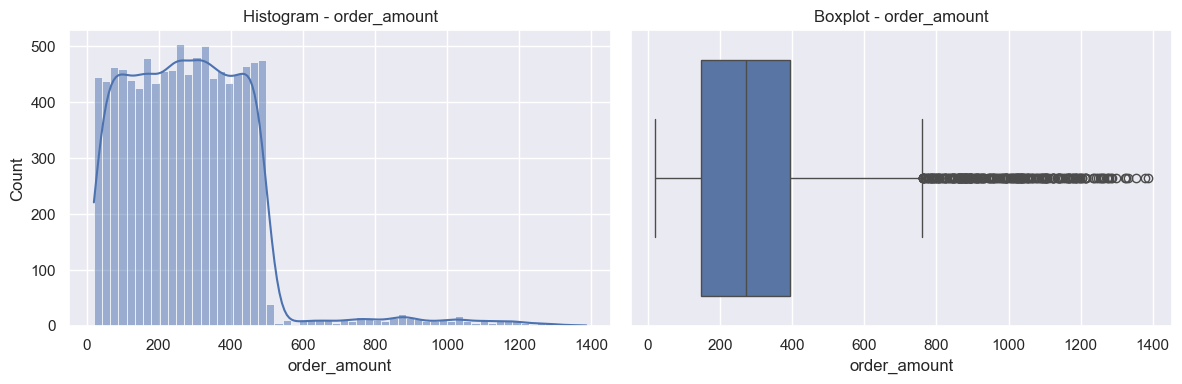

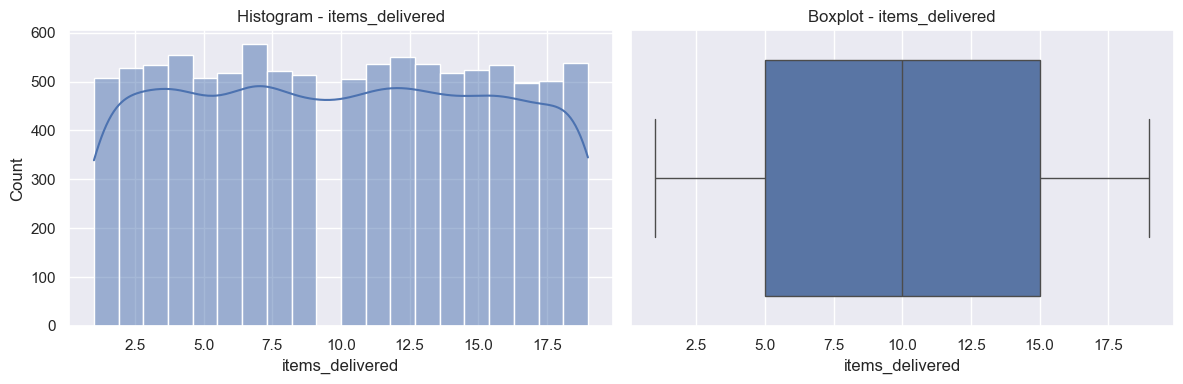

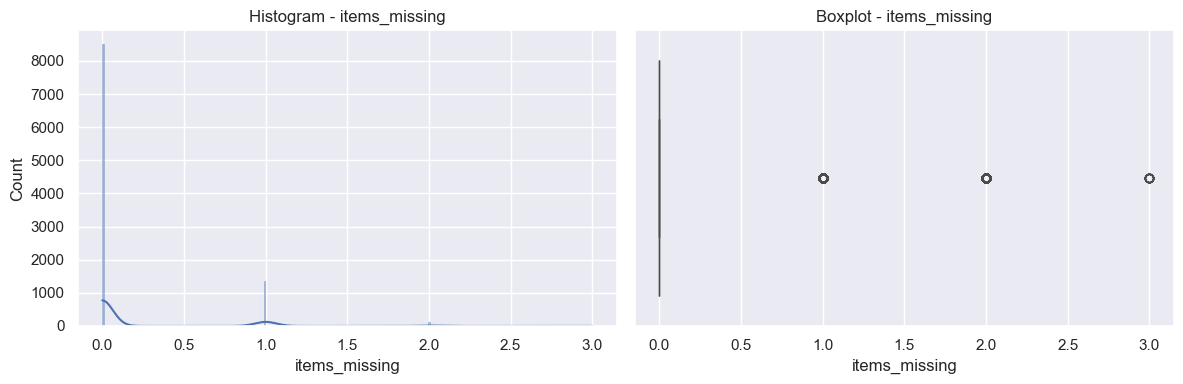

In [1094]:
variables_summary(df_orders_2, dataset_name='Orders')
variables_summary_plots(df_orders_2)

## 5.2 Missing Items Dataset

In [1095]:
variables_summary(df_missing_items_2, dataset_name='Missing Items')
variables_summary_plots(df_missing_items_2)

Dataset - Missing Items

 Categorical Summary:



,attribute,unique_values,most_frequent,frequency
0,order_id,1502,000e50be-92e8-46dc-9ff8-91a955b47ab7,1
1,missing_product_id_1,145,PWPX0982761090993,16
2,missing_product_id_2,103,PWPX0982761090982,2
3,missing_product_id_3,18,PWPX0982761090982,1


## 5.3 Products Dataset

Dataset - Products

 Numerical Summary:



,attribute,min,max,range,mean,median,std,skew,kurt,outliers_count
0,product_price,2.07,908.87,906.8,59.129936,11.275,164.990844,3.608371,12.285708,30



 Categorical Summary:



,attribute,unique_values,most_frequent,frequency
0,product_id,314,PWPX0982761090982,1
1,product_name,314,7 Up,1
2,product_category,11,Supermarket,115


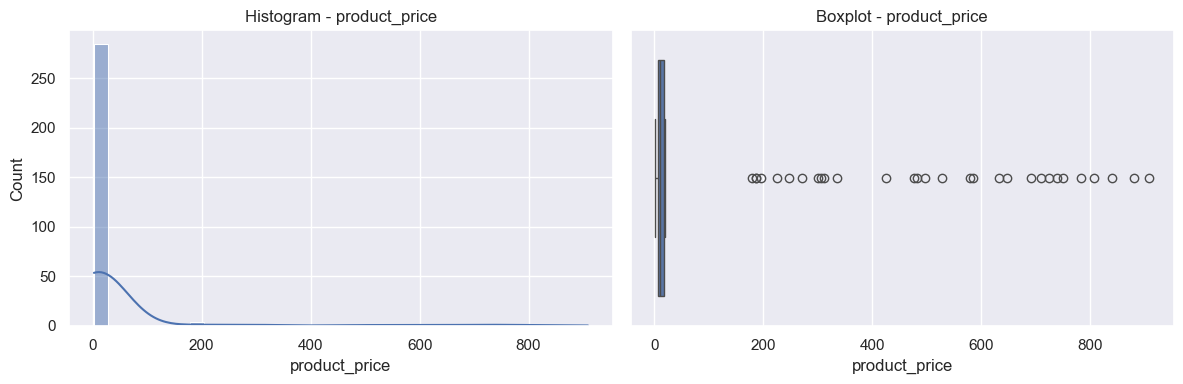

In [1096]:
# spliting numerical columns from categorical columns

variables_summary(df_products_2, dataset_name='Products')
variables_summary_plots(df_products_2)

## 5.4 Customers Dataset

Dataset - Customers

 Numerical Summary:



,attribute,min,max,range,mean,median,std,skew,kurt,outliers_count
0,customer_age,18.0,90.0,72.0,54.421308,55.0,20.911501,-0.030328,-1.190029,0



 Categorical Summary:



,attribute,unique_values,most_frequent,frequency
0,customer_id,1239,WCID5000,1
1,customer_name,1230,Angela Smith,2


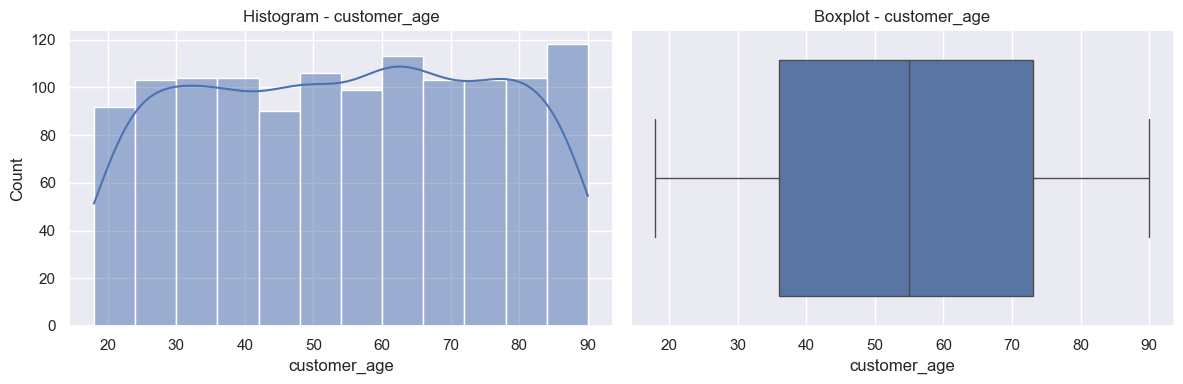

In [1097]:
variables_summary(df_customers_2, dataset_name='Customers')
variables_summary_plots(df_customers_2)

## 5.5 Drivers Dataset

Dataset - Drivers

 Numerical Summary:



,attribute,min,max,range,mean,median,std,skew,kurt,outliers_count
0,driver_age,18.0,65.0,47.0,34.170810,30.0,15.441928,0.547450,-1.137527,0
1,driver_trips,11.0,78.0,67.0,45.665597,46.0,19.747758,-0.049342,-1.203175,0



 Categorical Summary:



,attribute,unique_values,most_frequent,frequency
0,driver_id,1247,WDID09872,1
1,driver_name,1229,Ashley Brown,2


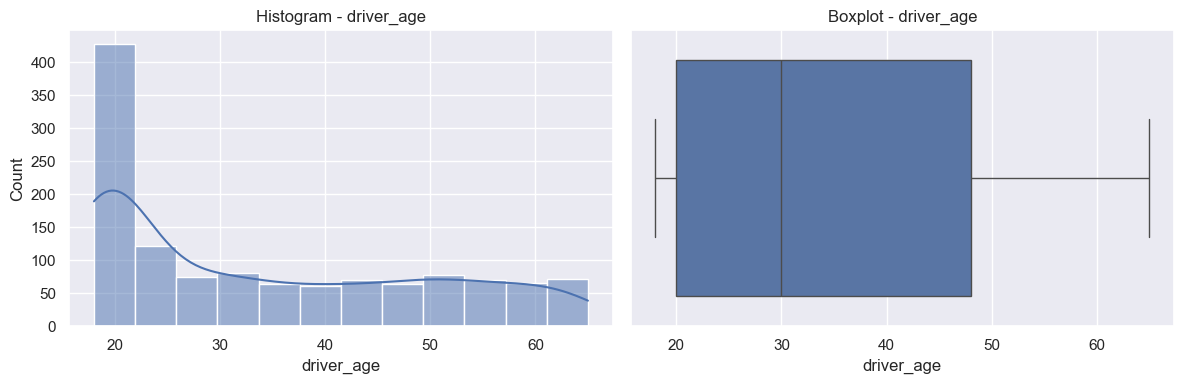

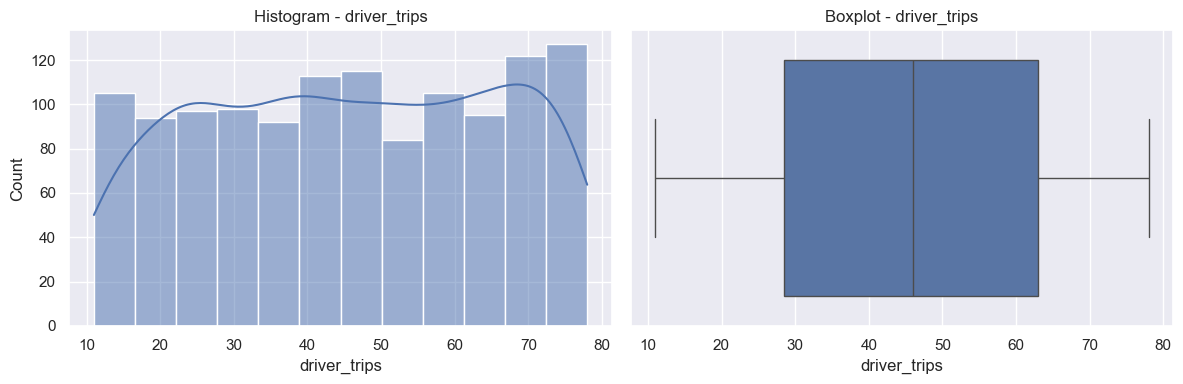

In [1098]:
variables_summary(df_drivers_2, dataset_name='Drivers')
variables_summary_plots(df_drivers_2)


## 5.6 Numerical Attributes – Distributional Behavior & Risk Implications

The numerical variables reveal distinct distributional patterns that may influence fraud risk detection and operational behavior.

Overall, monetary-related variables (e.g., order_amount and product_price) exhibit strong positive skewness and high kurtosis. This indicates a concentration of transactions at lower price levels combined with a small subset of extreme high-value observations.

Specifically:

Order Amount shows a wide range ($20 to $1386), with most orders concentrated below $500 but a heavy right tail driven by high-value purchases.

Product Price presents an even stronger disparity between median ($11) and maximum ($908), reinforcing the presence of extreme values likely associated with high-value product categories such as electronics.

This asymmetry suggests financial exposure is not evenly distributed across transactions. A small number of high-value orders may represent disproportionate operational and fraud risk.

In contrast, operational volume variables such as:

items_delivered

driver_trips

customer_age

driver_age

display approximately symmetric distributions with negative kurtosis (platykurtic behavior), indicating more evenly spread values and absence of heavy tails. These variables appear structurally stable and less influenced by extreme observations.

Note that for customer age, which there is a light positive skew, indicating marginal concentration of younger drivers, between 20 to 23 years.

The most critical variable from a fraud detection perspective is: 

Items Missing

This attribute exhibits strong right skewness (2.57) and high kurtosis (6.92), with a clear zero-inflated pattern. Most transactions have no missing items, while a small fraction contains one or more missing units.

Although statistically flagged as outliers under IQR rules, values above zero represent meaningful operational events rather than noise and should not be removed.

This distribution suggests that fraud-related behavior, if present, is concentrated in a small subset of transactions rather than being widespread across the dataset.

#### Overall: 

The dataset reveals structural asymmetry in financial variables and concentrated anomaly patterns in fulfillment behavior, suggesting that fraud risk is likely event-driven rather than systemic.

## 5.7 Categorical Attributes:

High-cardinality categorical variables such as driver_id and customer_id are not directly suitable for modeling and may require aggregation or encoding strategies.

# 6.0 Data Featuring

In [1099]:
df_orders_3 = df_orders_2.copy()
df_missing_items_3 = df_missing_items_2.copy()
df_products_3 = df_products_2.copy()
df_customers_3 = df_customers_2.copy()
df_drivers_3= df_drivers_2.copy()

## 6.1 Hyphotesis Creation

### 6.1.1 Seasonality Hyphotesis

H1: The missing item rate is significantly higher during night deliveries compared to morning and afternoon.

H2: Revenue loss due to missing items increases during seasonal peak periods (e.g., summer and year-end).

H3: Weekends deliveries presents higher missing item rates.

### 6.1.2 Location Hyphotesis

H4: Missing item rates differ significantly across regions.

H5: The average monetary loss per missing item differs significantly across regions.

### 6.1.3 Products Hyphotesis

H6: Eletronics are more frequently reported as missing item.

H7: Revenue loss per missing event is significantly higher for Electronics compared to Supermarket products.

H8: Missing frequency is inversely related to product price.

### 6.1.4 Customers Hyphotesis

H9: Missing item rates differ significantly across customer age groups.

H10: Revenue loss differ significantly across customer age groups.

### 6.1.5 Drivers Hyphotesis

H11: Drivers associated with multiple IDs exhibit higher missing item rates than drivers with a single ID.

H12: Drivers associated with multiple IDs exhibit higher revenue loss rates compared to drivers with a single ID.

H13: Missing item rates differ significantly across driver age groups.

H14: Missing item rate per trip increases with driver trip volume.

## 6.2 Findings but not Hyphotesis:

If not relevant after testing data, they might be excluded.

1. Revenue loss differ significantly across regions.

2. Within electronics, whatches are more reported as missing item. *

3. Within supermarket, beverages are more reported as missing item. *

4. Young adults represents the higher missing electronics items rate. * 

5. Young adults represents the higher missing revenue lost rate. *


## 6.3 Feature Engineering

### 6.3.1 Variables to be derivated from original variables

#### 6.3.1.1 Month

In [1100]:
df_orders_3['month'] = df_orders_3['date'].dt.month.astype('int64')

#### 6.3.1.2 Weekday

In [1101]:
df_orders_3['day_of_week'] = df_orders_3['date'].dt.day_name()

#### 6.3.1.3 Period Of The Day

In [1102]:
df_orders_3['hour'] = df_orders_3['delivery_hour'].dt.hour.astype('int64')

def period_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Night'

df_orders_3['period'] = df_orders_3['hour'].apply(period_of_day)

#### 6.3.1.4 Macro Category

In [1103]:
df_products_3['product_category'].value_counts()

product_category
Supermarket      115
Electronics       30
Bakery            22
Snacks            21
Household         21
Dairy             20
Pantry            19
Frozen            18
Produce           18
Beverages         17
Personal Care     13
Name: count, dtype: int64

Aside the Eletronics, all other categories are sub-categories from the macro category Supermaket. 
Therefore, a category called 'macro_category' will be createed to separate eletronics from groceries.

In [1104]:
df_products_3['macro_category'] = df_products_3['product_category'].apply(
    lambda x: 'Electronics' if x == 'Electronics' else 'Supermarket' )

## Moving the column 'macro_category' to the penultimate position.

##  Remove the column from the end
col = df_products_3.pop('macro_category')
## Insert the column in the desired position (penultimate).
df_products_3.insert(len(df_products_3.columns)-1, 'macro_category', col)

#### 6.3.1.5 Customers Age Group

In [1105]:
bins_customer = [18, 25, 40, 60, 90]
labels_customer = ['Young Adult', 'Adult', 'Middle Age', 'Senior']

df_customers_3['customer_age_group'] = pd.cut(df_customers_3['customer_age'],
                                              bins=bins_customer,labels=labels_customer,right=True,include_lowest=True).astype('object')


#### 6.3.1.6 Drivers Age Group

In [1106]:
bins_driver = [18, 25, 40, 55, 65]
labels_driver = ['Young', 'Adult', 'Experienced', 'Senior']

df_drivers_3['driver_age_group'] = pd.cut(df_drivers_3['driver_age'],
                                          bins=bins_driver,labels=labels_driver,right=True,include_lowest=True).astype('object')

#### 6.3.1.7 Missing Flag

This column identifies if a order have at least one missing item (1) or not (0).

It is used to verify the missing rate.

With this column, it is possible to calculate the probability of a order have at least one missing item.

" Whats is probability of a order have at least one missing item?"

This is occurrence rate.



In [1107]:
df_orders_3['missing_flag'] = (df_orders_3['items_missing'] > 0).astype(int)

#### 6.3.1.8 Revenue Loss

In order to create this variable, it is necessary to merge the datasets df_orders_3, df_missing_items_3and df_products_3.

In [1108]:
df = pd.merge(df_orders_3, df_missing_items_3, on='order_id', how='left')

In [1109]:
df.head().T

,0,1,2,3,4
date,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00
order_id,c9da15aa-be24-4871-92a3-dfa7746fff69,ccacc183-09f8-4fd5-af35-009d18656326,f4e1d30b-c3d1-413f-99b8-93c0b46d68bf,993d31f4-9358-41f0-a371-0021e55cef5d,3e0a8f1b-3cd6-4d64-90e3-6b38dc368925
order_amount,1095.54,659.11,251.45,598.83,27.18
region,Winter Park,Altamonte Springs,Winter Park,Altamonte Springs,Clermont
items_delivered,10,11,18,12,3
items_missing,1,1,1,1,1
delivery_hour,1900-01-01 08:37:28,1900-01-01 09:31:17,1900-01-01 10:43:49,1900-01-01 09:48:33,1900-01-01 10:09:49
driver_id,WDID10627,WDID10533,WDID10559,WDID10622,WDID10654
customer_id,WCID5031,WCID5794,WCID5599,WCID5005,WCID5114
month,1,1,1,1,1


In [1110]:
#Merging df_orders_4 with df_missing_items_4.
df = pd.merge(df_orders_3, df_missing_items_3, on='order_id', how='left')

# merging df with df_products_4.
df_merge_1 = df.copy()

# Sufix list (1, 2, 3).
for i in [1, 2, 3]:
    
    df_merge_1 = df_merge_1.merge(
        df_products_3,
        left_on=f'missing_product_id_{i}',
        right_on='product_id',
        how='left'
    )
    
   # Renaming columns.
    df_merge_1 = df_merge_1.rename(columns={
        'product_name': f'product_name_{i}',
        'product_category': f'product_category_{i}',
        'macro_category': f'macro_category_{i}',
        'product_price': f'product_price_{i}'
    })
    
    # Removing auxiliar comumn.
    df_merge_1 = df_merge_1.drop(columns=['product_id'])

#Converting NAN values to 0 for the price columns
price_cols = [f'product_price_{i}' for i in [1, 2, 3]]
df_merge_1[price_cols] = df_merge_1[price_cols].fillna(0)

# Creating revenue loss variable.
df_merge_1['revenue_loss'] = df_merge_1[price_cols].sum(axis=1)

# Reordering columns.
base_cols = [
'date', 'order_id', 'order_amount', 'region',
'items_delivered', 'items_missing', 'missing_flag',
'delivery_hour', 'driver_id', 'customer_id',
'revenue_loss', 'month', 'day_of_week', 'hour', 'period'
]

product_cols = []

for i in [1, 2, 3]:
    product_cols.extend([
        f'missing_product_id_{i}',
        f'product_name_{i}',
        f'product_category_{i}',
        f'macro_category_{i}',
        f'product_price_{i}'
    ])

df_merge_1 = df_merge_1[base_cols + product_cols]

#### 6.3.1.7.1 Revenue Loss validation by items missing

Checking if the revenue loss variable is statistically coherent with the items missing variable, in ordder worlds,if this variable was correctly created and make mathematical sense.

In [1111]:
# Variable description.

df_merge_1[['items_missing','revenue_loss']].describe()

,items_missing,revenue_loss
count,10000.00000,10000.000000
mean,0.16570,14.938269
std,0.41432,88.696161
min,0.00000,0.000000
25%,0.00000,0.000000
50%,0.00000,0.000000
75%,0.00000,0.000000
max,3.00000,922.000000


In [1112]:
# Basic Logical Validation.

df_merge_1[df_merge_1['items_missing'] == 0]['revenue_loss'].sum()

np.float64(0.0)

In [1113]:
# Statistical relationship between items_missing and revenue_loss.

df_merge_1[['items_missing','revenue_loss']].corr()

,items_missing,revenue_loss
items_missing,1.000000,0.372755
revenue_loss,0.372755,1.000000


In [1114]:
# Mean by items quantity.

df_merge_1.groupby('items_missing')['revenue_loss'].mean()

items_missing
0      0.000000
1    101.170228
2     87.376412
3     37.170000
Name: revenue_loss, dtype: float64

In [1115]:
# inconsistent Verfification.

df_merge_1[
    (df_merge_1['items_missing'] > 0) &
    (df_merge_1['revenue_loss'] == 0)
]

,date,order_id,order_amount,region,items_delivered,items_missing,missing_flag,delivery_hour,driver_id,customer_id,...,missing_product_id_2,product_name_2,product_category_2,macro_category_2,product_price_2,missing_product_id_3,product_name_3,product_category_3,macro_category_3,product_price_3


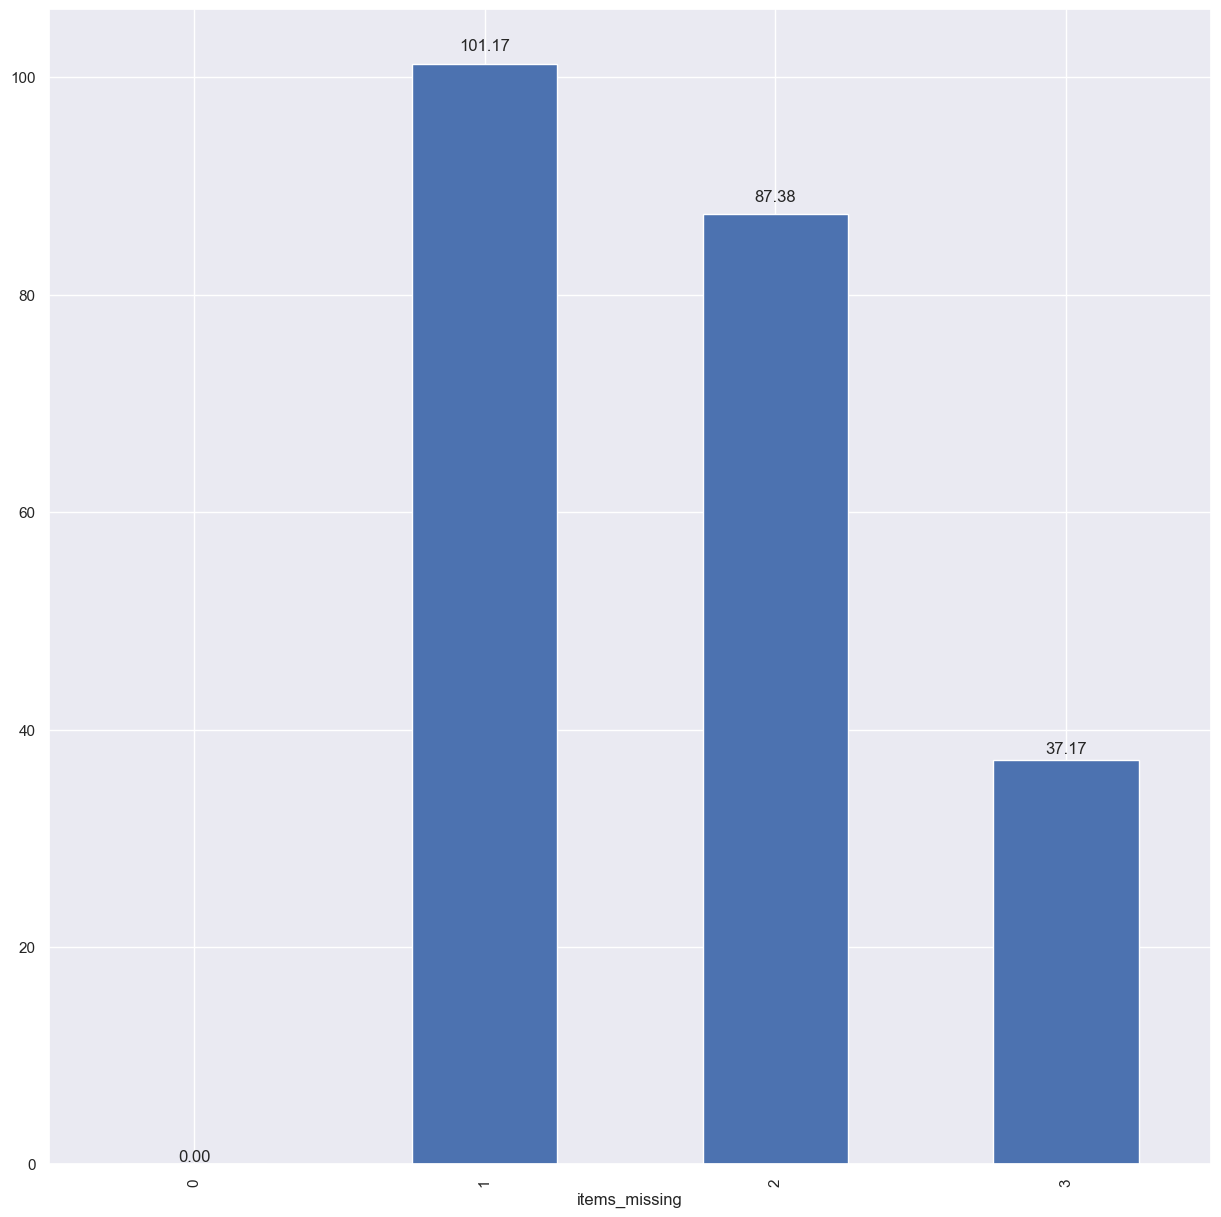

In [1116]:
# Growth Visualization. 

plot_0 = df_merge_1.groupby('items_missing')['revenue_loss'].mean().plot(kind='bar')
bar_value(plot_0)

Revenue loss was validated to ensure structural consistency, showing zero loss for orders without missing items and a positive monotonic relationship with number of missing items."

In [1117]:
df_merge_1.head().T 

,0,1,2,3,4
date,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00
order_id,c9da15aa-be24-4871-92a3-dfa7746fff69,ccacc183-09f8-4fd5-af35-009d18656326,f4e1d30b-c3d1-413f-99b8-93c0b46d68bf,993d31f4-9358-41f0-a371-0021e55cef5d,3e0a8f1b-3cd6-4d64-90e3-6b38dc368925
order_amount,1095.54,659.11,251.45,598.83,27.18
region,Winter Park,Altamonte Springs,Winter Park,Altamonte Springs,Clermont
items_delivered,10,11,18,12,3
items_missing,1,1,1,1,1
missing_flag,1,1,1,1,1
delivery_hour,1900-01-01 08:37:28,1900-01-01 09:31:17,1900-01-01 10:43:49,1900-01-01 09:48:33,1900-01-01 10:09:49
driver_id,WDID10627,WDID10533,WDID10559,WDID10622,WDID10654
customer_id,WCID5031,WCID5794,WCID5599,WCID5005,WCID5114


# 7.0 Variables Filter

In order to know which sub-categories are significant for the analysis, it is necessary to verify the missing items per sub-category.

In [1118]:
print(df_merge_1.loc[df_merge_1['items_missing'] != 0, 'product_category_1'].value_counts(), end='\n\n')
print(df_merge_1.loc[df_merge_1['items_missing'] != 0, 'product_category_2'].value_counts(), end='\n\n')
print(df_merge_1.loc[df_merge_1['items_missing'] != 0, 'product_category_3'].value_counts(), end='\n\n')

product_category_1
Supermarket    1233
Electronics     269
Name: count, dtype: int64

product_category_2
Supermarket    143
Name: count, dtype: int64

product_category_3
Supermarket    18
Name: count, dtype: int64



In [1119]:
print(df_merge_1.groupby('product_category_1')['order_id'].count(), end='\n\n')
print(df_merge_1.groupby('product_category_2')['order_id'].count() , end='\n\n')
print(df_merge_1.groupby('product_category_3')['order_id'].count())

product_category_1
Electronics     269
Supermarket    1233
Name: order_id, dtype: int64

product_category_2
Supermarket    143
Name: order_id, dtype: int64

product_category_3
Supermarket    18
Name: order_id, dtype: int64


All the products that were not delivered are from the Supermarket category or Electronics category, therefore, it is not relelevant to run an analysis by sub-category level, to verify if there is any sub-category that has a higher amount of missing products.

Additonally, there is no need to verify if the products are correctly categorized on the sub-category level.

# 8.0 Exploratory Data Analysis (EDA)

In [1120]:
df_orders_4 = df_orders_3.copy()
df_missing_items_4 = df_missing_items_3.copy()
df_products_4 = df_products_3.copy()
df_customers_4 = df_customers_3.copy()
df_drivers_4= df_drivers_3.copy()
df_merge_ord_miss_prod = df_merge_1.copy()

## 8.1 Univariate Analsis

### 8.1.1 Response Variables

Checking the response variales only on items_missing > 0, since the revenue_loss is only relevant when there are missing items.

In [1121]:
df_res_var =df_merge_ord_miss_prod[df_merge_ord_miss_prod['items_missing'] > 0].reset_index(drop=True)

#### 8.1.1.1 Items Missing

##### How manny items were not delivered? 

The total of missing items is 1502


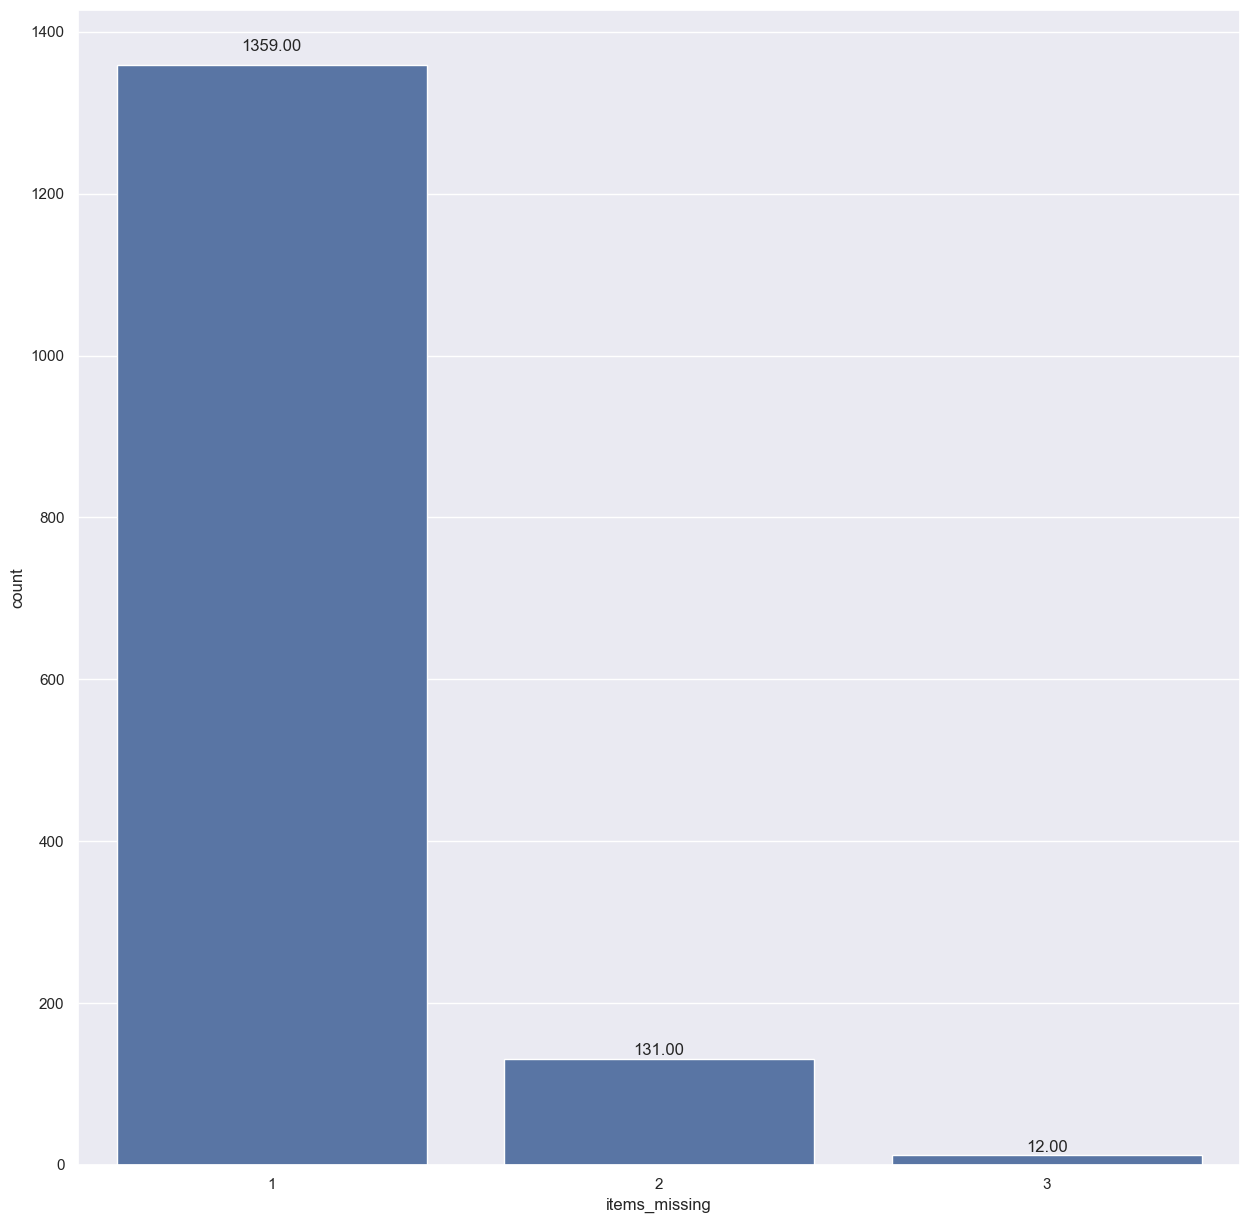

In [1122]:
# plot_1 = df_res_var['items_missing'].value_counts().plot(kind='bar')
# bar_value(plot_1)

plot_1 = sns.countplot(x="items_missing",data=df_res_var, dodge=True)
bar_value(plot_1)

print('The total of missing items is', df_res_var['items_missing'].count())

#### 8.1.1.2 Revenue Loss

What is the total revenue lost due to these undelivered items?

The total of revenue loss is $ 149382.69


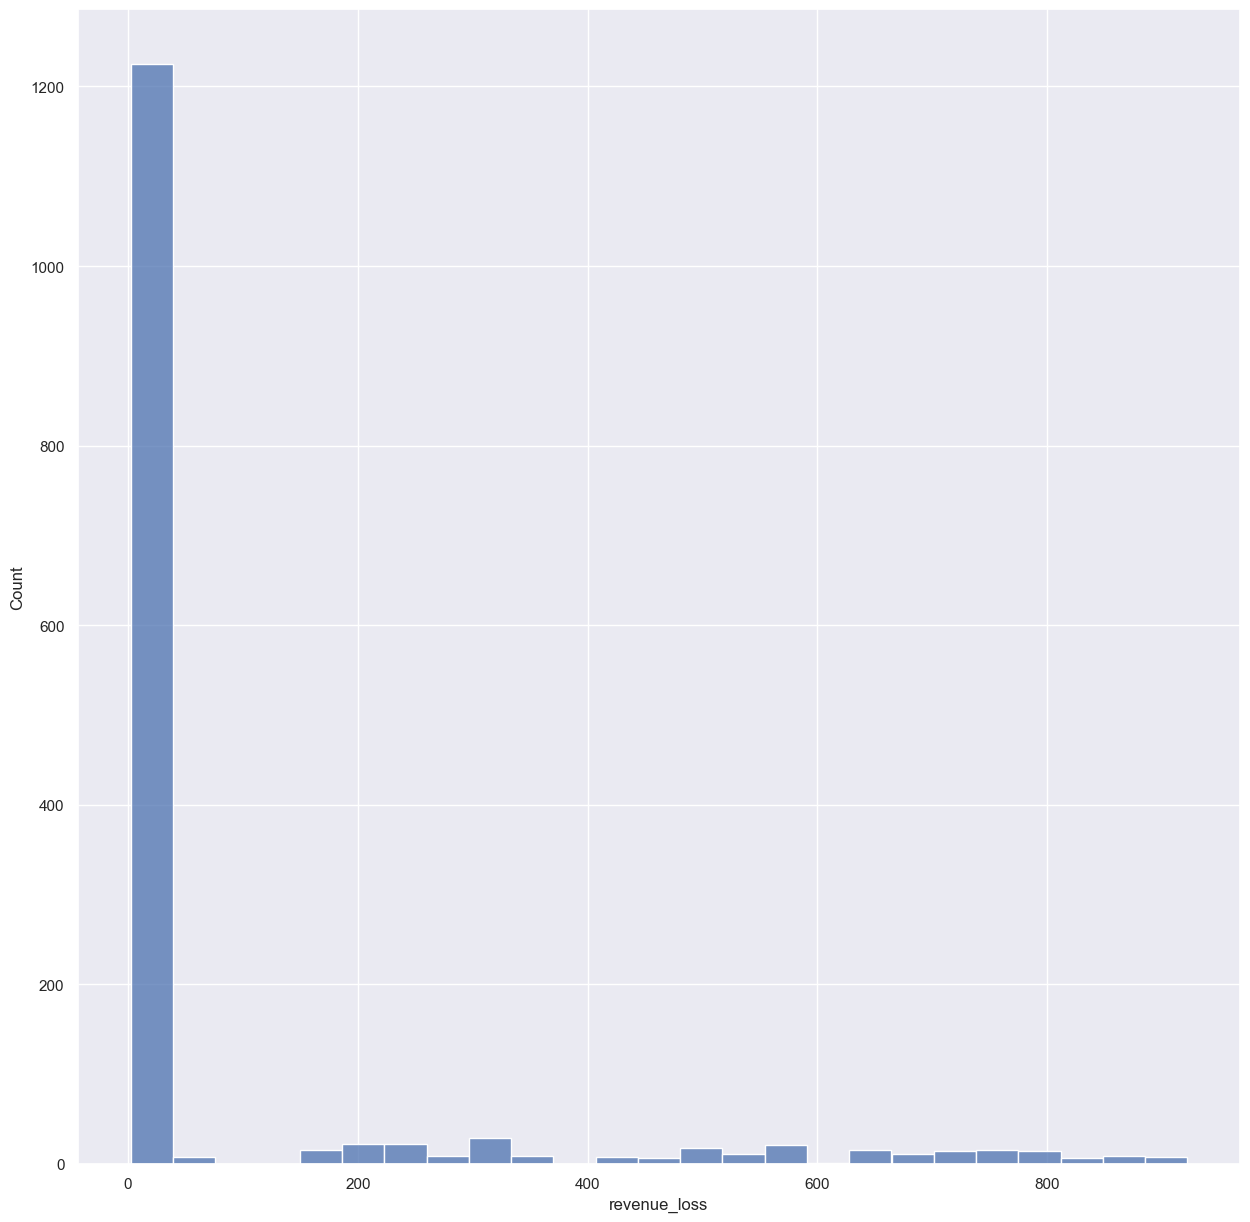

In [1123]:
sns.set(rc={"figure.figsize": (15, 15)})
sns.histplot(df_res_var['revenue_loss'], bins = 25)

print('The total of revenue loss is $', df_res_var['revenue_loss'].sum())

High skew and kurtosis. The variable revenue_loss has a high skew and kurtosis, which indicates that the distribution is not normal and has a long tail to the right. 
This suggests that there are some orders with very high revenue loss compared to the majority of orders, which may indicate that a small number of orders are responsible for a large portion of the total revenue loss.

## 8.2 Bivariate Analsis

### 8.2.1 Missing Rate and Revenue Loss Rate per Dimensions

It is possible to calculate the probability of a order have at least one missing item (missing rate) using the column 'missing_flag'.

" Whats is probability of a order have at least one missing item?"

This is occurrence rate.

In [1124]:
# Calculating general average (general missing rate and revenue loss)
overall_missing_rate = df_merge_ord_miss_prod['missing_flag'].mean()
overall_revenue_loss = df_merge_ord_miss_prod['revenue_loss'].mean()

print("Overall Missing Rate:", overall_missing_rate, end='\n\n')
print("Overall Revenue Loss:", overall_revenue_loss)

Overall Missing Rate: 0.1502

Overall Revenue Loss: 14.938269


#### 8.2.2.1 Seasonality


--- Analysis for: period ---
Total groups (after volume filter): 3
Groups above average: 1 (33.33%)


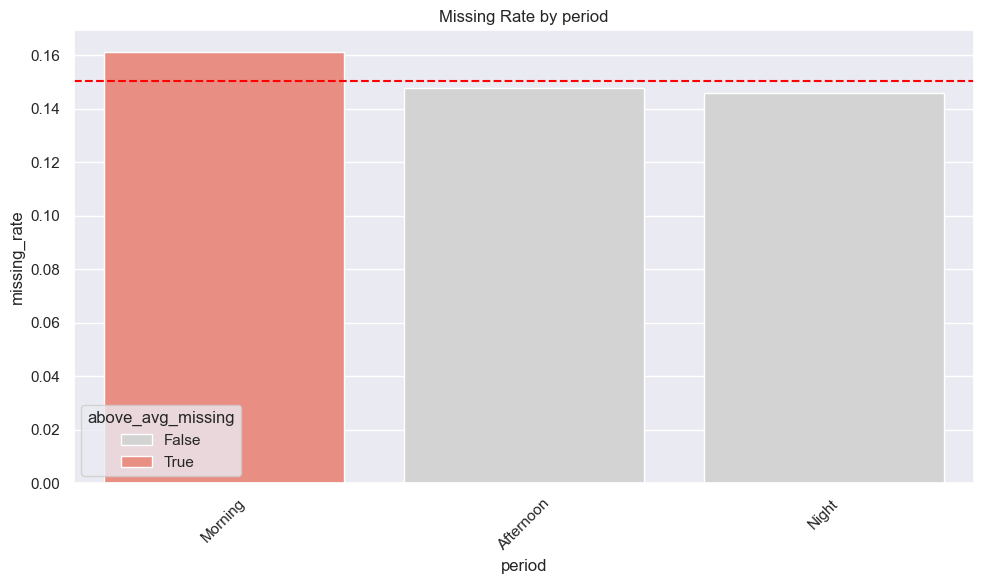

,period,missing_rate,avg_revenue_loss,total_orders,above_avg_missing
1,Morning,0.161225,15.885042,2481,True
0,Afternoon,0.147664,15.041722,2526,False
2,Night,0.146004,14.415484,4993,False


In [1125]:
# Calculating general avverage (general missing rate and revenue loss) per period of day

period_results = analyze_missing_rate(df_merge_ord_miss_prod, 'period', overall_missing_rate)
period_results

#### 8.2.2.2 Location


--- Analysis for: region ---
Total groups (after volume filter): 7
Groups above average: 4 (57.14%)


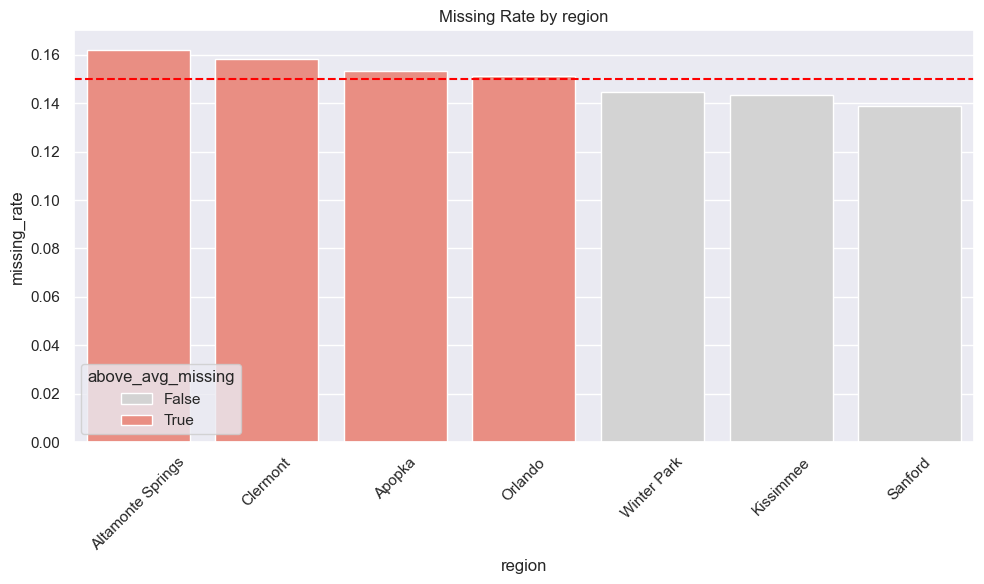

,region,missing_rate,avg_revenue_loss,total_orders,above_avg_missing
0,Altamonte Springs,0.161992,16.512062,1426,True
2,Clermont,0.158237,13.443945,1384,True
1,Apopka,0.153305,13.439086,1422,True
4,Orlando,0.151320,19.497873,1401,True
6,Winter Park,0.144781,15.705589,1485,False
3,Kissimmee,0.143561,13.459838,1421,False
5,Sanford,0.138946,12.562587,1461,False


In [1126]:
# Calculating general avverage (general missing rate and revenue loss) per region

driver_results = analyze_missing_rate(df_merge_ord_miss_prod, 'region', overall_missing_rate)
driver_results

#### 8.2.2.3 Product


--- Analysis for: macro_category_1 ---
Total groups (after volume filter): 2
Groups above average: 2 (100.00%)


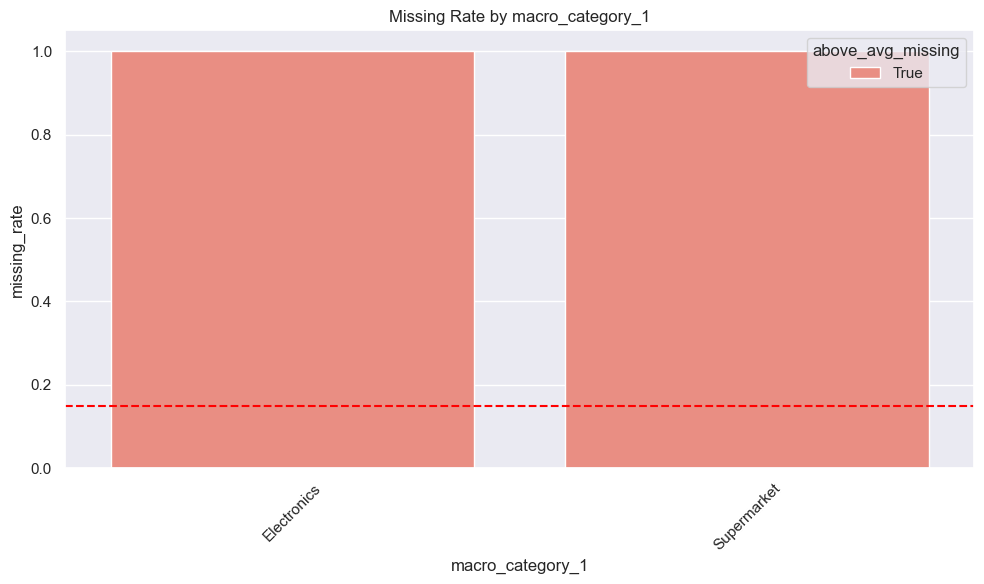

,macro_category_1,missing_rate,avg_revenue_loss,total_orders,above_avg_missing
0,Electronics,1.0,496.537323,269,True
1,Supermarket,1.0,12.825750,1233,True


In [1127]:
# Calculating general avverage (general missing rate and revenue loss) per macro_category

driver_results = analyze_missing_rate(df_merge_ord_miss_prod, 'macro_category_1', overall_missing_rate)
driver_results

#### 8.2.2.4 Customes

In [1128]:
# Calculating general avverage (general missing rate and revenue loss) per customers

driver_results = analyze_missing_rate(df_merge_ord_miss_prod, 'customer_id', overall_missing_rate)
driver_results


--- Analysis for: customer_id ---
Total groups (after volume filter): 358
Groups above average: 173 (48.32%)


,customer_id,missing_rate,avg_revenue_loss,total_orders,above_avg_missing
685,WCID5685,0.583333,122.300833,12,True
820,WCID5820,0.466667,6.745333,15,True
7,WCID5007,0.428571,17.535000,14,True
653,WCID5653,0.400000,130.511000,10,True
817,WCID5817,0.400000,7.253000,10,True
...,...,...,...,...,...
156,WCID5156,0.000000,0.000000,11,False
98,WCID5098,0.000000,0.000000,13,False
1156,WCID6156,0.000000,0.000000,11,False
1174,WCID6174,0.000000,0.000000,11,False


#### 8.2.2.5 Drivers

In [1129]:
# Calculating general avverage (general missing rate and revenue loss) per drivers

driver_results = analyze_missing_rate(df_merge_ord_miss_prod, 'driver_id', overall_missing_rate)
driver_results


--- Analysis for: driver_id ---
Total groups (after volume filter): 425
Groups above average: 425 (100.00%)


,driver_id,missing_rate,avg_revenue_loss,total_orders,above_avg_missing
674,WDID10546,0.363636,65.236364,11,True
673,WDID10545,0.363636,4.264545,11,True
672,WDID10544,0.363636,69.580909,11,True
193,WDID10065,0.363636,52.158182,11,True
192,WDID10064,0.363636,21.345455,11,True
...,...,...,...,...,...
804,WDID10676,0.272727,2.995455,11,True
805,WDID10677,0.272727,74.866364,11,True
806,WDID10678,0.272727,55.790000,11,True
807,WDID10679,0.272727,4.150909,11,True


### 8.2.2 Validating Hyphotesis

H1: The missing item rate is significantly higher during night deliveries compared to morning and afternoon.

In [ ]:
# Count plot vertical
plot_1 = df.groupby('period')['items_missing'].count().plot(kind='bar')
bar_value(plot_1, decimals=0)  # count -> sem casas decimais

# Mean plot vertical
plot_2 = df.groupby('period')['items_missing'].mean().plot(kind='bar')
bar_value(plot_2, decimals=2)  # média -> 2 casas decimais

# Horizontal bar plot
plot_3 = df.groupby('period')['items_missing'].mean().plot(kind='barh')
bar_value(plot_3, decimals=2, vertical=False)

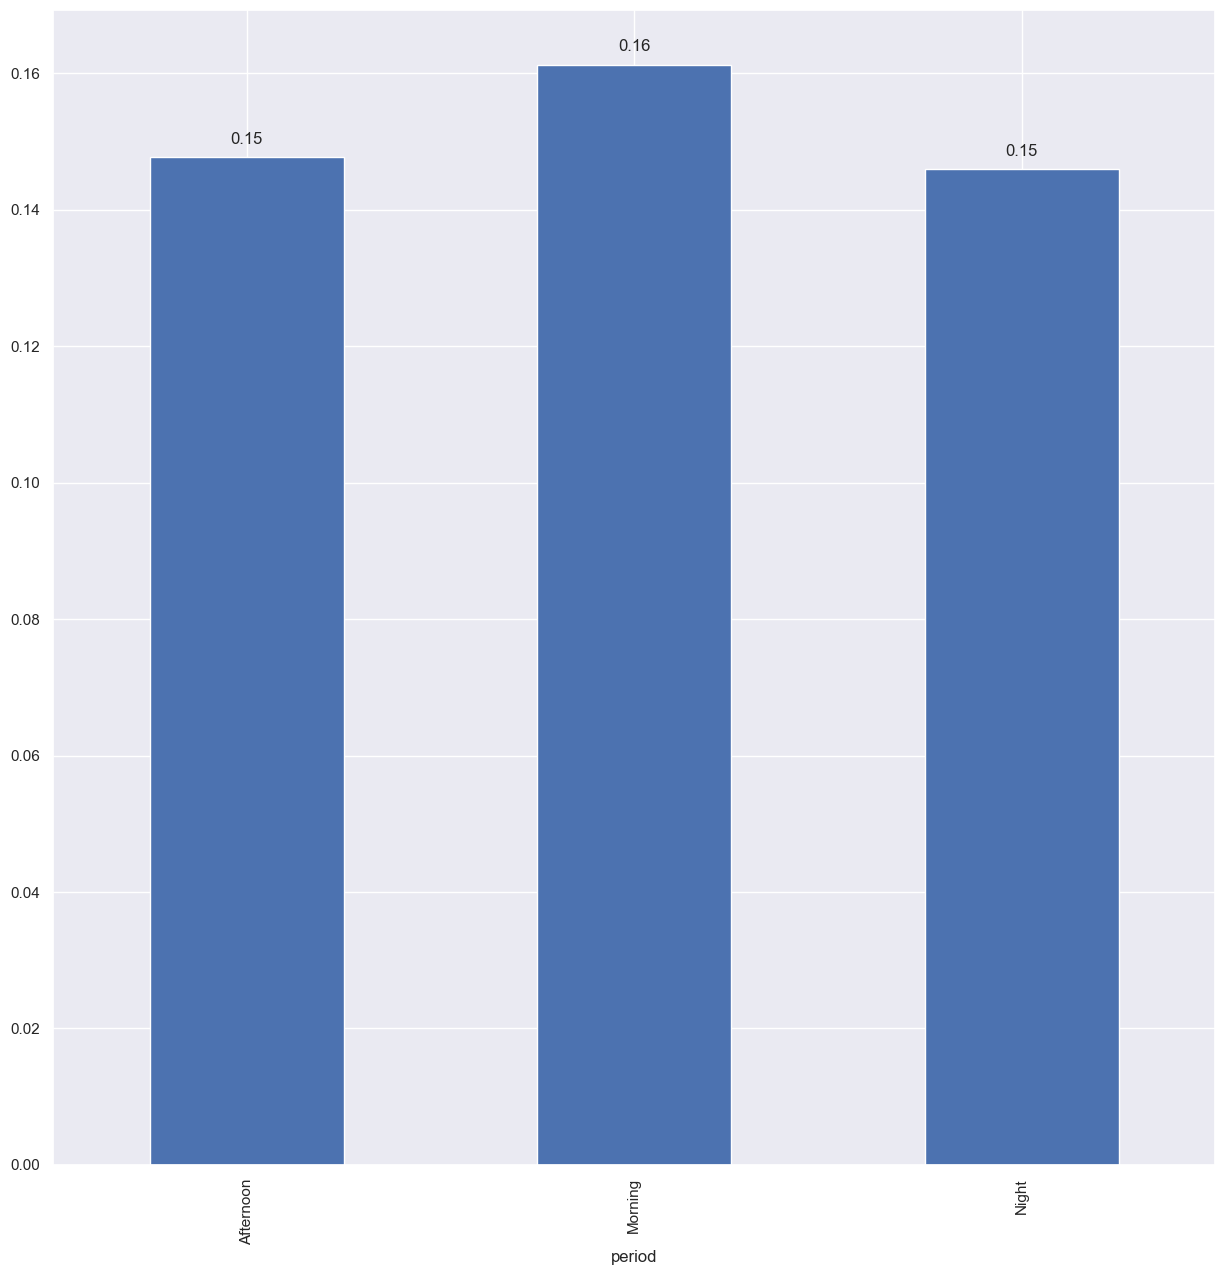

In [1141]:
# plt.subplot(1,2,1)
aux = df_merge_ord_miss_prod.groupby('period')['missing_flag'].mean().plot(kind='bar')
bar_value(aux, decimals=2)

# plt.subplot(1,2,2)
# aux2 = df_merge_ord_miss_prod[['month', 'period', 'missing_flag']].groupby(['month', 'period']).mean().reset_index()
# sns.barplot(x = 'month', y = 'missing_flag', hue = 'period', data = aux2);

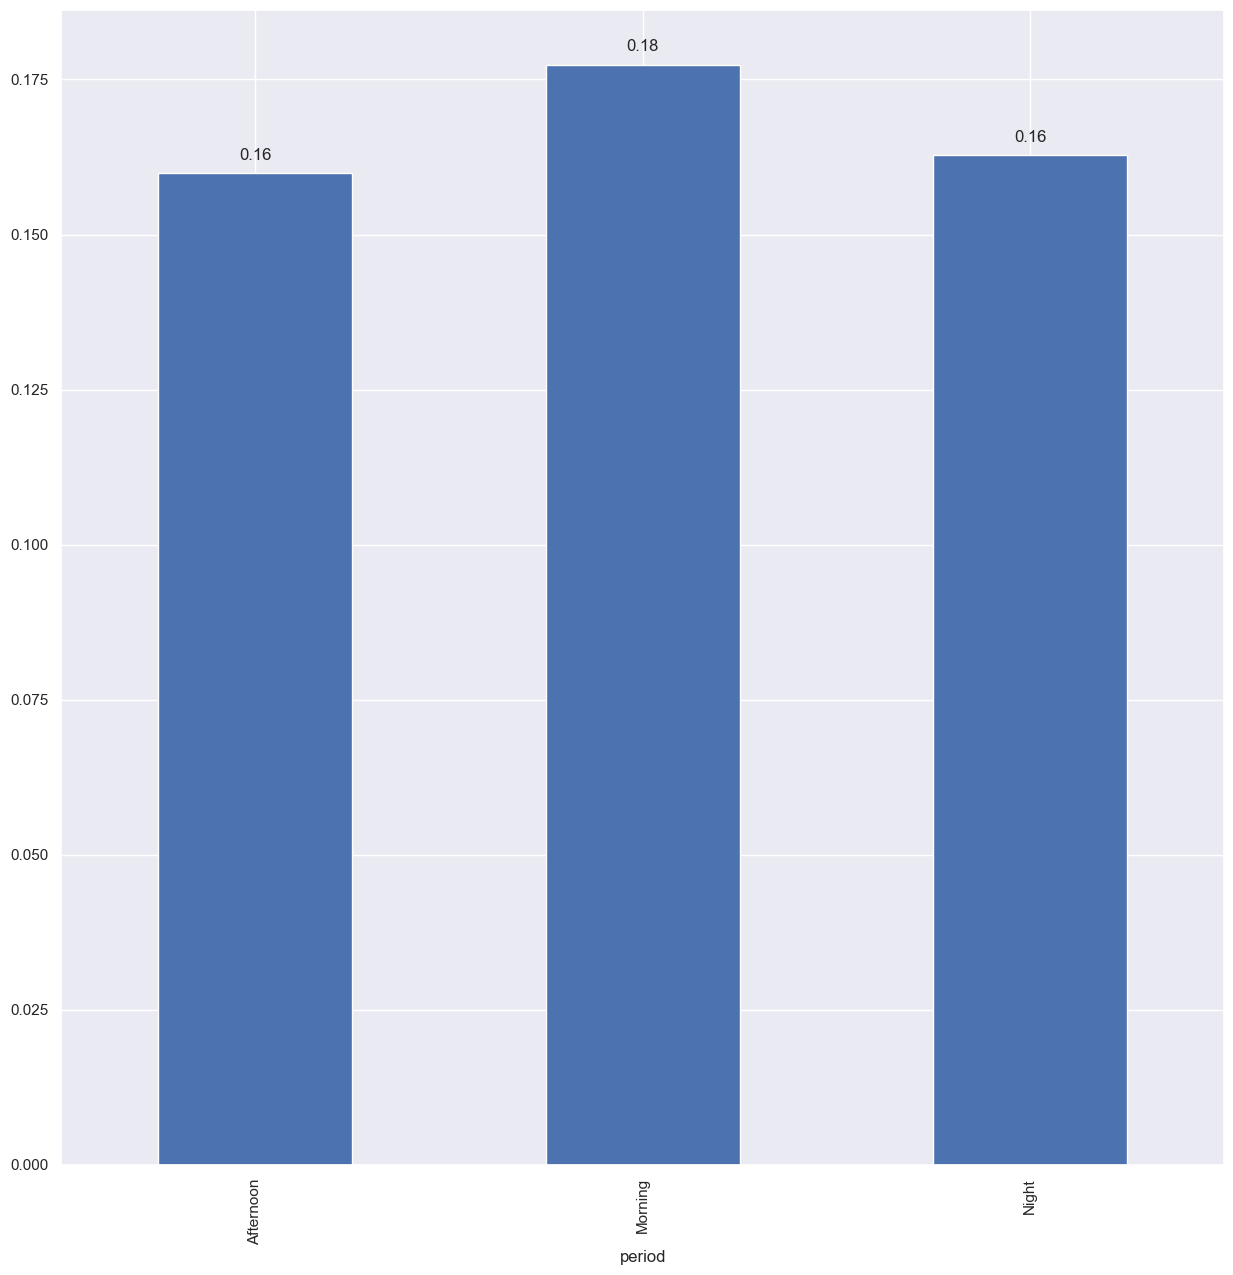

In [1142]:
# plt.subplot(1,2,1)
aux = df_merge_ord_miss_prod.groupby('period')['items_missing'].mean().plot(kind='bar')
bar_value(aux, decimals=2)

# plt.subplot(1,2,2)
# aux2 = df_merge_ord_miss_prod[['month', 'period', 'items_missing']].groupby(['month', 'period']).mean().reset_index()
# sns.barplot(x = 'month', y = 'items_missing', hue = 'period', data = aux2);

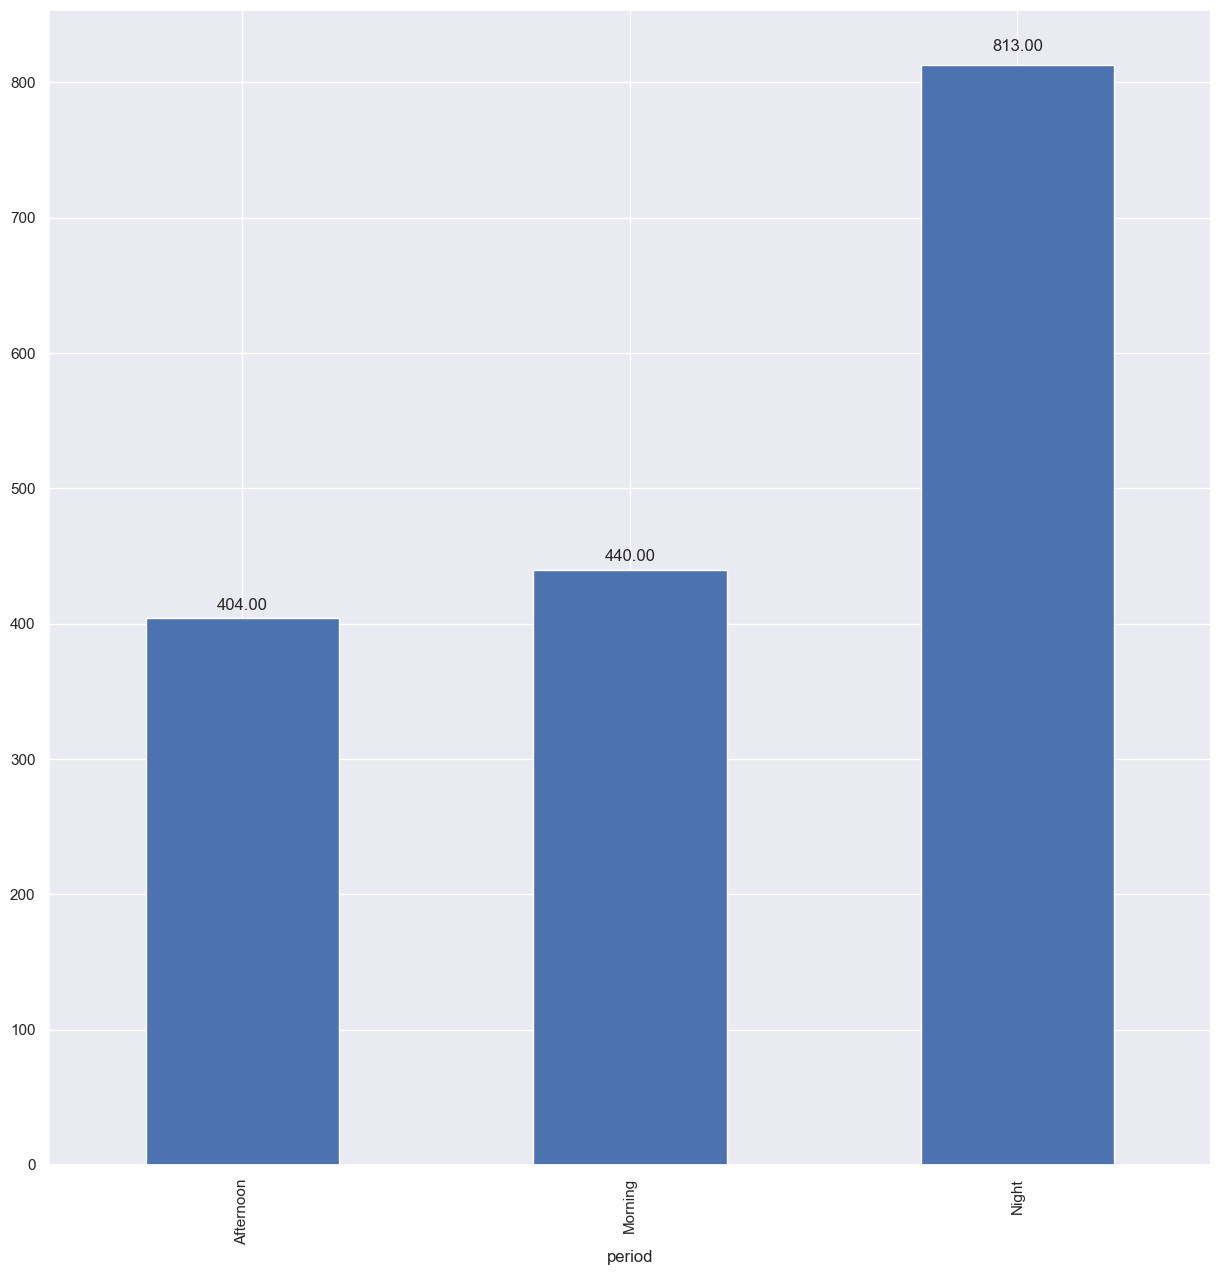

In [1143]:
# plt.subplot(1,2,1)
aux = df_merge_ord_miss_prod.groupby('period')['items_missing'].sum().plot(kind='bar')
bar_value(aux, decimals=2)

# plt.subplot(1,2,2)
# aux2 = df_merge_ord_miss_prod[['month', 'period', 'items_missing']].groupby(['month', 'period']).sum().reset_index()
# sns.barplot(x = 'month', y = 'items_missing', hue = 'period', data = aux2);

H2: Revenue loss due to missing items increases during seasonal peak periods (e.g., summer and year-end).

H3: Weekends deliveries presents higher missing item rates.

H4: Missing item rates differ significantly across regions.

H5: The average monetary loss per missing item differs significantly across regions.

H6: Eletronics are more frequently reported as missing item.


H7: Revenue loss per missing event is significantly higher for Electronics compared to Supermarket products.

H8: Missing frequency is inversely related to product price.

H9: Missing item rates differ significantly across customer age groups.

H10: Revenue loss differ significantly across customer age groups.

H11: Drivers associated with multiple IDs exhibit higher missing item rates than drivers with a single ID.

H12: Drivers associated with multiple IDs exhibit higher revenue loss rates compared to drivers with a single ID.

H13: Missing item rates differ significantly across driver age groups.

H14: Missing item rate per trip increases with driver trip volume.

1. Revenue loss differ significantly across regions.

2. Within electronics, whatches are more reported as missing item. *

3. Within supermarket, beverages are more reported as missing item. *

4. Young adults represents the higher missing electronics items rate. * 

5. Young adults represents the higher missing revenue lost rate. *

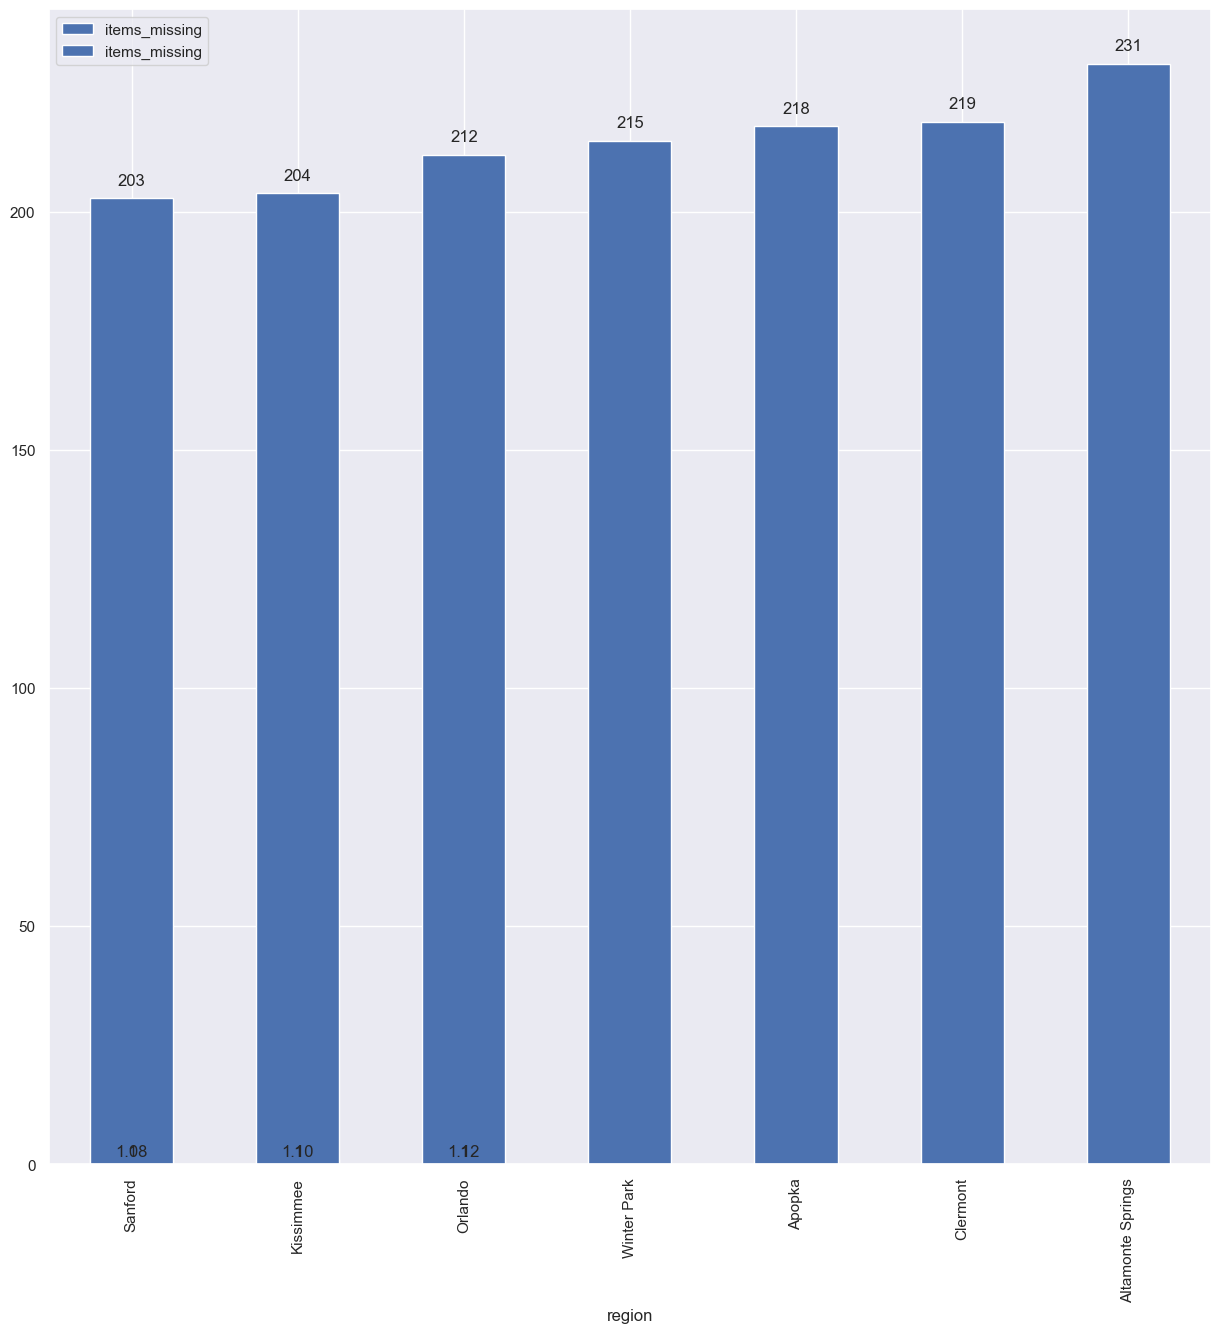

In [1131]:
# Seasonality Analysis.
##period
plot_2 = df_res_var.groupby('period')['items_missing'].mean().plot(kind='bar', legend=True)
bar_value(plot_2)

#Location Analysis.
## region
plot_3 = df_res_var.groupby('region')['items_missing'].count().sort_values(ascending=True).plot(kind='bar', legend=True)
bar_value(plot_3, decimals=0)

# Products Analysis.
## macro_category

# Customers Analysis.
## customer_age_group

# Missing rate per Drivers.
## driver_age_group



#### 8.1.2.2 Revenue lost

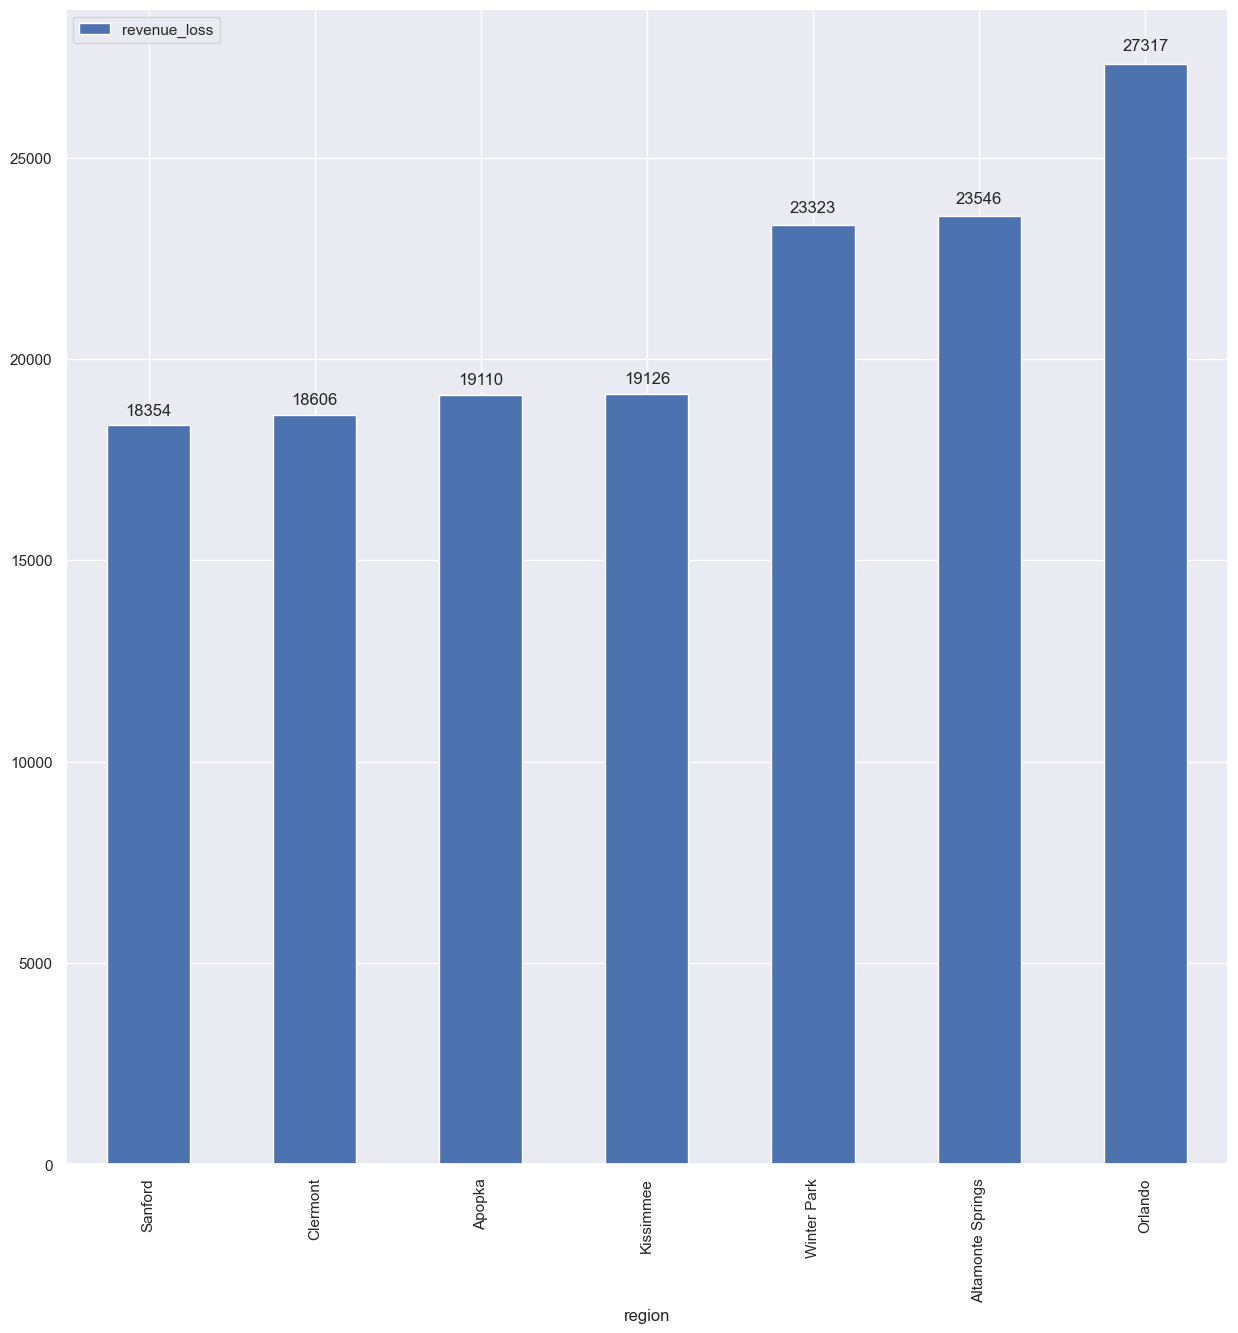

In [1132]:
# Seasonality Analysis.
##period
# plot_2 = df_res_var.groupby('period')['revenue_loss'].mean().plot(kind='bar', legend=True)
# bar_value(plot_2)

#Location Analysis.
## region
plot_3 = df_res_var.groupby('region')['revenue_loss'].sum().sort_values(ascending=True).plot(kind='bar', legend=True)
bar_value(plot_3, decimals=0)

# Products Analysis.
## macro_category

# Customers Analysis.
## customer_age_group

# Drivers Analysis.
## driver_age_group

In [1133]:
df_merge_ord_miss_prod.columns

Index(['date', 'order_id', 'order_amount', 'region', 'items_delivered',
       'items_missing', 'missing_flag', 'delivery_hour', 'driver_id',
       'customer_id', 'revenue_loss', 'month', 'day_of_week', 'hour', 'period',
       'missing_product_id_1', 'product_name_1', 'product_category_1',
       'macro_category_1', 'product_price_1', 'missing_product_id_2',
       'product_name_2', 'product_category_2', 'macro_category_2',
       'product_price_2', 'missing_product_id_3', 'product_name_3',
       'product_category_3', 'macro_category_3', 'product_price_3'],
      dtype='object')

pergunta sobre a ultima explicacao: entao a soma eh usada para valores relacionados a moeda por exemplo, onde nnao precisa se basaer em outro dado, ja a media e usado para valores de intensidae, onde tem q se comparar com outro dado, por exemplo, a quantidade de produtos entregues?